# Проект для «Викишоп» с BERT

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

**ВАЖНЫЙ ДИСКЛЕЙМЕР**

В данной работе используется BERT, поэтому прохождение всех этапов занимает довольно много времени (лемматизация порядка 25 минут, подготовка эмбеддингов еще 20 минут и обучение всех моделей около 2 часов).
Работа выполнялась локально с GPU.

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Чтение-данных" data-toc-modified-id="Чтение-данных-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Чтение данных</a></span></li><li><span><a href="#Предобработка-данных" data-toc-modified-id="Предобработка-данных-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Предобработка данных</a></span></li><li><span><a href="#Выводы-по-разделу" data-toc-modified-id="Выводы-по-разделу-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Выводы по разделу</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Разделение-выборок" data-toc-modified-id="Разделение-выборок-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Разделение выборок</a></span></li><li><span><a href="#Способы-извлечения-фичей-(преобразование-текста-в-вектор)" data-toc-modified-id="Способы-извлечения-фичей-(преобразование-текста-в-вектор)-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Способы извлечения фичей (преобразование текста в вектор)</a></span></li><li><span><a href="#Вспомогательные-функции" data-toc-modified-id="Вспомогательные-функции-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Вспомогательные функции</a></span></li><li><span><a href="#Обучение-моделей" data-toc-modified-id="Обучение-моделей-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Обучение моделей</a></span><ul class="toc-item"><li><span><a href="#LogisticRegression-с-поиском-гиперпараметров." data-toc-modified-id="LogisticRegression-с-поиском-гиперпараметров.-2.4.1"><span class="toc-item-num">2.4.1&nbsp;&nbsp;</span>LogisticRegression с поиском гиперпараметров.</a></span></li><li><span><a href="#LinearSVC--с-поиском-гиперпараметров." data-toc-modified-id="LinearSVC--с-поиском-гиперпараметров.-2.4.2"><span class="toc-item-num">2.4.2&nbsp;&nbsp;</span>LinearSVC  с поиском гиперпараметров.</a></span></li><li><span><a href="#DecisionTree-с-поиском-гиперпараметров." data-toc-modified-id="DecisionTree-с-поиском-гиперпараметров.-2.4.3"><span class="toc-item-num">2.4.3&nbsp;&nbsp;</span>DecisionTree с поиском гиперпараметров.</a></span></li><li><span><a href="#LGBMClassifier--с-поиском-гиперпараметров." data-toc-modified-id="LGBMClassifier--с-поиском-гиперпараметров.-2.4.4"><span class="toc-item-num">2.4.4&nbsp;&nbsp;</span>LGBMClassifier  с поиском гиперпараметров.</a></span></li></ul></li><li><span><a href="#Анализ-моделей" data-toc-modified-id="Анализ-моделей-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>Анализ моделей</a></span></li><li><span><a href="#Выводы-по-разделу" data-toc-modified-id="Выводы-по-разделу-2.6"><span class="toc-item-num">2.6&nbsp;&nbsp;</span>Выводы по разделу</a></span></li></ul></li><li><span><a href="#Тестирование-лучшей-модели" data-toc-modified-id="Тестирование-лучшей-модели-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Тестирование лучшей модели</a></span></li><li><span><a href="#Выводы-по-исследованию" data-toc-modified-id="Выводы-по-исследованию-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Выводы по исследованию</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

## Подготовка

In [100]:
#!pip install wordcloud
#!pip install transformers

In [1]:
# сразу импортируем все необходимые библиотеки
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords, wordnet
from nltk.probability import FreqDist
from wordcloud import WordCloud, STOPWORDS

import re
import spacy as sp
from tqdm import notebook, tqdm

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.feature_extraction.text import TfidfVectorizer 

from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.dummy import DummyClassifier

import torch
import transformers

from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay

import warnings
warnings.filterwarnings('ignore') 

sns.set(font_scale=2,
        style='whitegrid',
        rc={'figure.figsize': (22, 8)})

# тут задам глобальную переменную рандома, чтобы не прописывать ее вручную каждый раз
RANDOM = 12345

In [2]:
# на локальной машине есть GPU, укажем его как устройство по умолчанию, если доступно

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE

device(type='cuda')

In [3]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords') 

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\strog\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\strog\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\strog\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Чтение данных

Прочитаем исходные данные (в качестве индекса сразу возьмем первую колонку), выведем случайные 10 строк, общую информацию о датасете (вместе с информацией об абсолютном и относительном количестве пропусков), основные статистики по столбцам и количество явных дубликатов.

Для удобства работы весь процесс реализуем через функции.

In [4]:
try:
    comments = pd.read_csv('toxic_comments.csv', index_col=[0])
except:
    comments = pd.read_csv('/datasets/toxic_comments.csv', index_col=[0])

In [5]:
comments['text'] = comments['text'].values.astype('U')

In [6]:
def nans(df):
    '''функция выводит количество пропусков в каждом столбце и их долю от общего количества данных в столбце'''
    
    count_missing = df.isna().sum()
    percent_missing = round(df.isna().sum() * 100 / len(df), 2)
    
    missing_value_df = pd.DataFrame({'num_missing': count_missing,
                                     'percent_missing': percent_missing})
    
    return missing_value_df.reset_index().rename(columns={'index':'column'})

In [7]:
def info_dataframe(data, details=False):
    '''функция преобразует df.info() в датафрейм'''
    
    dfInfo = data.columns.to_frame(name='column')
    dfInfo['dtype'] = data.dtypes
    dfInfo['non_null_count'] = data.notna().sum()  
    dfInfo.reset_index(drop=True, inplace=True)
    
    if details:
        rangeIndex = (dfInfo['non_null_count'].min(), dfInfo['non_null_count'].min())
        totalColumns = dfInfo['column'].count()
        dtypesCount = dfInfo['dtype'].value_counts()
        totalMemory = dfInfo.memory_usage().sum()
        return dfInfo, rangeIndex, totalColumns, dtypesCount, totalMemory
    else:
        return dfInfo

In [8]:
def all_info(df):
    '''функция выводит случайные 10 строк, информацию по датафрейму, включая пропуски и их долю, статистики и кол-во дубликатов'''
    
    display(df.sample(10))
    print(f'Датафрейм содержит {df.shape[0]} записей и {df.shape[1]} колонки')
    all_info_df = info_dataframe(df).merge(nans(df), on='column')
    display(all_info_df)
    display(df.describe().T)
    print(f'Количество явных дубликатов в датафрейме {df.duplicated().sum()}')

In [9]:
all_info(comments)

,text,toxic
125998,", this information is easily assesible on the ...",0
5618,"Welcome!\n\nHello, , and welcome to Wikipedia!...",0
63563,you are a cunt \n\nHello Mr Jim ....\n\nMy rea...,1
6189,Okay I have followed your advice. I created a ...,0
95010,""", 29 November 2006 (UTC)\n\nDon't think so th...",0
129846,"""\n\n Thank you. First of all, if you're going...",0
149969,Here Why the Argentina HDI's is Wrong \n\nHere...,0
115754,"""\n\n Please do not vandalize pages, as you di...",0
20682,Please don't touch my talk page anymore. What...,0
83219,"Stop baiting ME! 21:46, 30 Jan 2005 (UTC)",0


Датафрейм содержит 159292 записей и 2 колонки


,column,dtype,non_null_count,num_missing,percent_missing
0,text,object,159292,0,0.0
1,toxic,int64,159292,0,0.0


,count,mean,std,min,25%,50%,75%,max
toxic,159292.0,0.101612,0.302139,0.0,0.0,0.0,0.0,1.0


Количество явных дубликатов в датафрейме 0


В нашем распоряжении набор данных с разметкой о токсичности комментариев.

Датасет содержит 159292 записи и две колонки:

- `text` типа object - текст комментария, 
- `toxic` целочисленного типа - целевой признак, оценка токсичности комментария (1 - токсичный, 0 - не токсичный).

Пропусков и явных дубликатор не обнаружено.

Текст комментариев на английском языке, в нем присутствуют различные символы, такие как буквы разных регистров, знаки пунктуации и переноса строк, возможно, цифры.

Для дальнейшей реализации обучения моделей важно понимать, как распределена целевая переменная и сблансированы ли классы. Рассмотрим это с помощью визуализации.

In [10]:
def visualize_groups(groups):
    '''функция визуализация распределения классов'''
    
    fig, ax = plt.subplots()

    groups.plot(kind='bar').set_title('Количество комментариев по группам\n', fontdict={'fontsize': 25})

    ax.set_xticklabels(['\nНе токсичные', '\nТоксичные'], rotation=0, fontsize=25)

    # добавим числовые обозначения
    for rect in ax.patches:
        ax.text(rect.get_x() + rect.get_width() / 2, 
                rect.get_height()+ 0.75, 
                rect.get_height(), horizontalalignment='center', fontsize = 20);

In [11]:
groups_raw = comments['toxic'].value_counts()
groups_raw

0    143106
1     16186
Name: toxic, dtype: int64

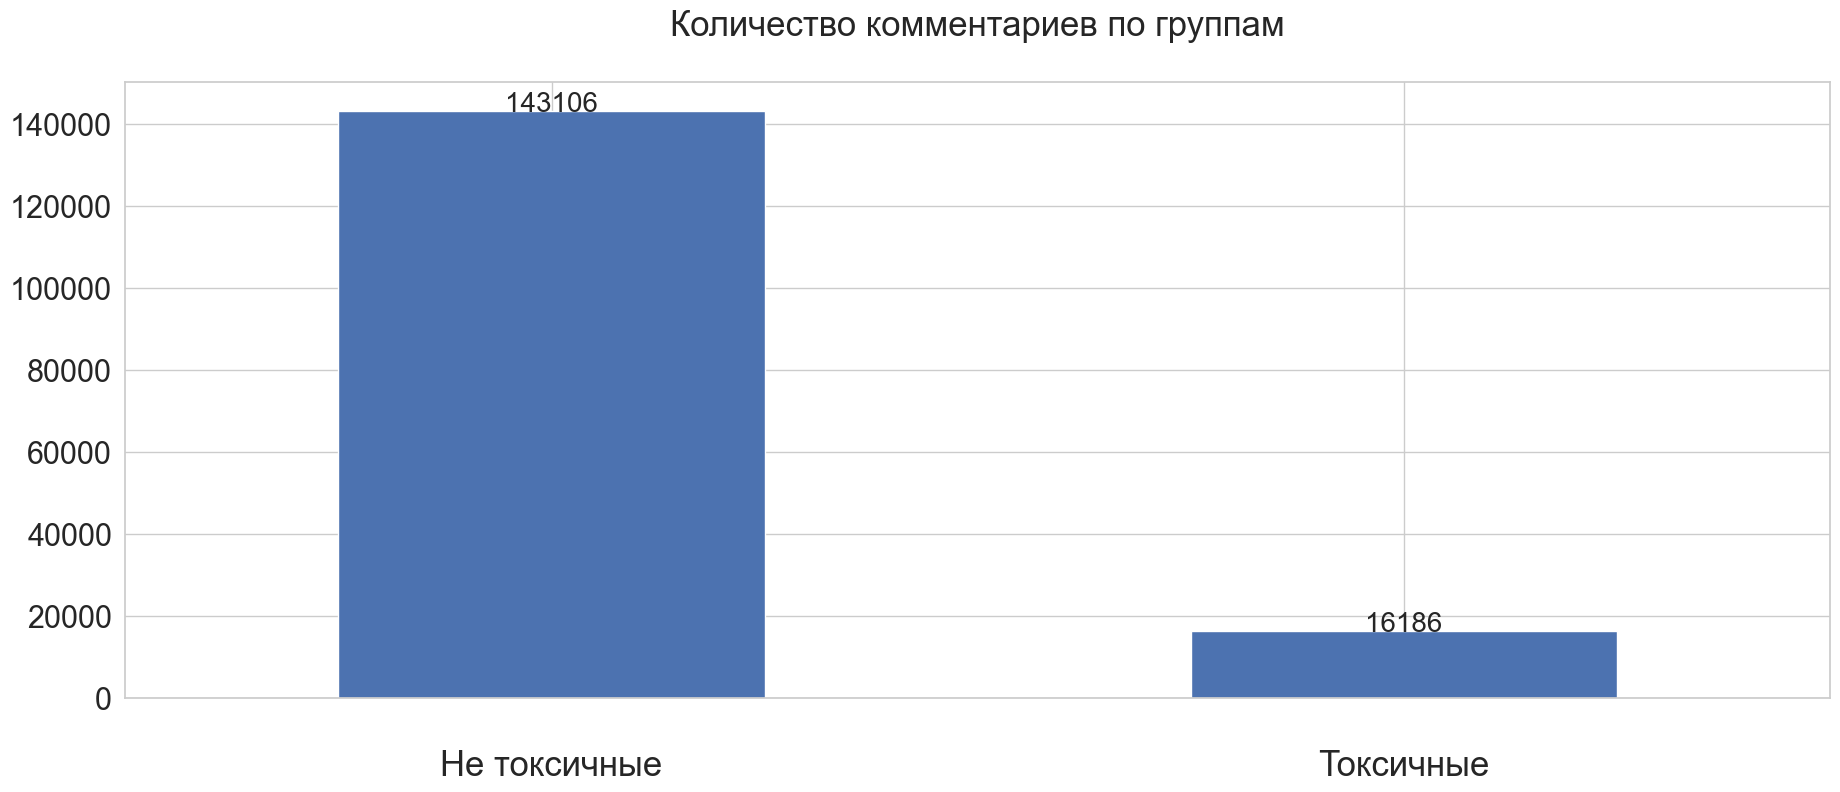

In [12]:
visualize_groups(groups_raw)

Очевидно, что не токсичных комментариев намного больше, чем токсичных - это объясняется здравым смыслом и спецификой задачи. Таким образом, классы НЕ сбалансированы, соотношение токсичных комментариев к нетоксичным около 1 к 9, и нам нужно будет учесть это при построении моделей.

### Предобработка данных

Для того, чтобы продолжить работу с текстом, нужно выполнить предобработку:

- удалить все символы, кроме буквенных (например, цифры и пунктуацию),
- убрать лишние пробелы,
- провести лемматизацию,
- привести текст в нижнему регистру.

In [13]:
lemma_encoder = sp.load('en_core_web_sm')

def preprocessing(text):
    '''функция возвращает отредактированный текст'''
    
    new_text = re.sub(r'[^a-zA-Z]', ' ', text) # удаляем всё кроме букв
    new_text = ' '.join(new_text.split()) # убираем лишние пробелы
    new_text = [token.lemma_ for token in lemma_encoder(new_text)] # проводим лемматизацию
    new_text = ' '.join(new_text) 
    return new_text.lower() # возвращаем текст в нижнем регистре

**Дисклеймер** Следующая ячейка отрабатывает около 23 минут на локальной машине с CUDA.

In [14]:
tqdm.pandas()
comments['text'] = comments['text'].progress_apply(preprocessing)

100%|█████████████████████████████████████████████████████████████████████████| 159292/159292 [25:06<00:00, 105.73it/s]


Посмотрим на то, как изменились наши данные в результате предобработки.

In [15]:
all_info(comments)

,text,toxic
5848,precede unsigned comment add by talk contrib h...,0
145107,an editor push i off the article in the way it...,0
100090,image delete i think image be delete from arti...,0
32158,how come the killing of islamist fighter only ...,0
138095,widr s p n two words small as f,1
5935,what s the problem with this author he be a fa...,0
115178,thank thank for the barnstar,0
117162,so yes some people with uniform latitude may u...,0
41414,birth announcement i be proud to announce the ...,0
71348,wait i have an idea,0


Датафрейм содержит 159292 записей и 2 колонки


,column,dtype,non_null_count,num_missing,percent_missing
0,text,object,159292,0,0.0
1,toxic,int64,159292,0,0.0


,count,mean,std,min,25%,50%,75%,max
toxic,159292.0,0.101612,0.302139,0.0,0.0,0.0,0.0,1.0


Количество явных дубликатов в датафрейме 1308


После обработки у нас появилось 1308 явных дубликатов. Так как для обучения они никакой уникальной информации нести не будут, то их нужно удалить.

In [16]:
comments = comments.drop_duplicates()
all_info(comments)

,text,toxic
67225,as a matter of fact for both the d and d case ...,0
1679,and more detail on his various position in the...,0
102467,insult you disgust i,1
143423,tag please don t tag suspect sock who be indef...,0
3891,silly edit on this edit of yours wikipedia aim...,0
101747,i think we have all have enough of your extrem...,0
32533,utc if france germany and japan be list as cur...,0
114739,if you argue that taiwan and republic of china...,0
15307,why wouldn t it be appropriate for there to be...,0
82613,cycle chart i believe that the previous cycle ...,0


Датафрейм содержит 157984 записей и 2 колонки


,column,dtype,non_null_count,num_missing,percent_missing
0,text,object,157984,0,0.0
1,toxic,int64,157984,0,0.0


,count,mean,std,min,25%,50%,75%,max
toxic,157984.0,0.101656,0.302196,0.0,0.0,0.0,0.0,1.0


Количество явных дубликатов в датафрейме 0


Посмотрим, как распределяется по классам целевая переменная теперь.

In [17]:
groups_prep = comments['toxic'].value_counts()
groups_prep

0    141924
1     16060
Name: toxic, dtype: int64

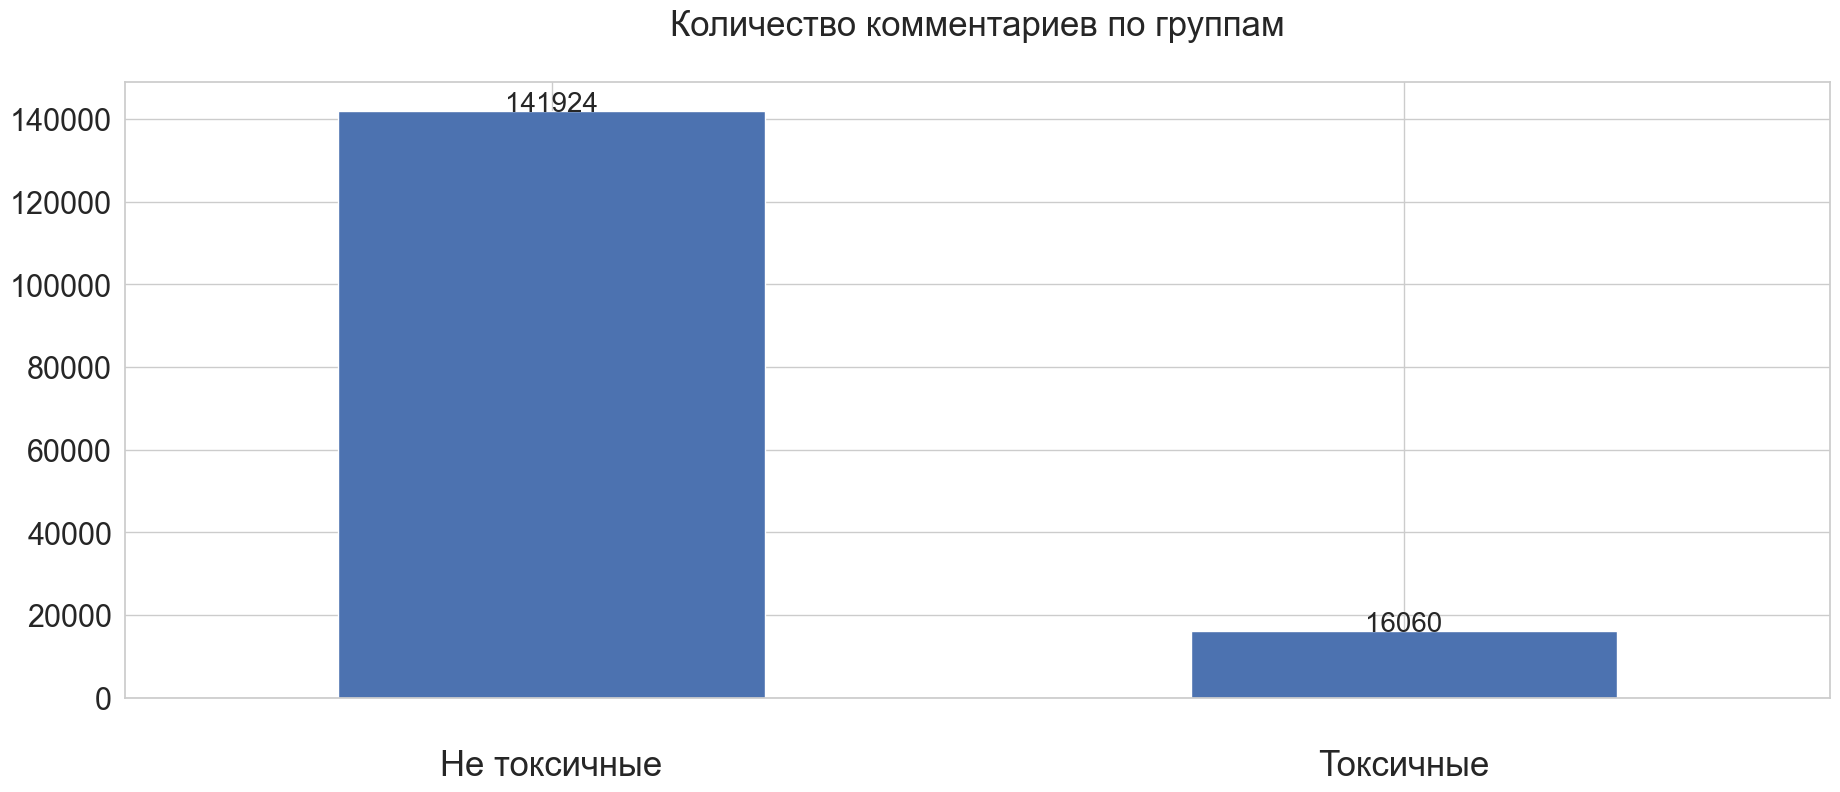

In [18]:
visualize_groups(groups_prep)

Хотя количество строк в датасете поменялось, пропорция дисбаланса классов осталась прежней.

### Выводы по разделу

Нами было проведено чтение сырых данных и их предобработка до приведения к виду, пригодному для подачи в модели машинного обучения.

- Изучены данные и их основные характеристики, общая информация о датасете, рассмотрено наличие пропусков и явных дубликатов;
- Рассмотрено и визуализировано распределение целевого признака (оценки токсичности комментария), обнаружен дисбаланс классов с примерным соотношением токсичных комментариев к нетоксичным как 1:9;
- Из текстов комметариев были удалены все НЕ буквенные символы, лишние пробелы, тест был приведен к нижнему регистру и лемматизирован (все слова приведены к начальном форме);
- После этой процедуры в датасете были обнаружены явные дубликаты, после чего они были удалены.

## Обучение

Перед обучение нужно провести несколько процедур:
    
- разделение выборок,
- задать способы превращения текстовой информации в векторное представление,
- написать функции для сбора и визуализации метрик (сам процесс будет включать поиск лучшим гиперпараметров с помощью GridSearchCV).

### Разделение выборок

Разделим датасет на обучающую, валидационную и тестовую выборки. На обучающей будем обучать модели, валидационную будем использовать для поиска лучшей модели, а тестовую (в размере 20% от исходного датасета) покажем только лучшей подели в самом конце.

In [19]:
features = comments['text']
target = comments['toxic']

In [20]:
X_tv, X_test, y_tv, y_test = train_test_split(features,
                                              target,
                                              stratify=comments['toxic'],
                                              random_state=RANDOM,
                                              test_size=0.2)

X_train, X_val, y_train, y_val = train_test_split(X_tv, 
                                                  y_tv,
                                                  test_size=0.2, 
                                                  random_state=RANDOM)

print(f'Размер признаков обучающей выборки {X_train.shape}, размер признаков тестовой выборки {X_test.shape}')
print(f'Размер обучающего таргета {y_train.shape}, размер тестового таргета {y_test.shape}')

Размер признаков обучающей выборки (101109,), размер признаков тестовой выборки (31597,)
Размер обучающего таргета (101109,), размер тестового таргета (31597,)


In [21]:
X_train.head()

125247    hangon franklin dam this be close to the probl...
102569    copyright status of image naa png please do no...
111482                            tx dgg i add some thought
142720    this be the memo that i mean by the way my ger...
135560    july utc i think we have all establish that yo...
Name: text, dtype: object

In [22]:
y_train.head()

125247    0
102569    0
111482    0
142720    0
135560    1
Name: toxic, dtype: int64

In [23]:
y_train.value_counts()

0    90835
1    10274
Name: toxic, dtype: int64

In [24]:
y_test.value_counts()

0    28385
1     3212
Name: toxic, dtype: int64

При разделении выборок дисбаланс классов сохранен в той же пропорции.

### Способы извлечения фичей (преобразование текста в вектор)

Сначала создадим `TfidfVectorizer`, с нужными нам параметрами, которые можно взять из документации

https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html

- с помощью `strip_accents` можно удалить акценты,
- зададим параметр `stop_words` для удаления английских стоп-слов (не несущие смысла предлоги, частицы - их можно загрузить из пакета `nltk`),
- с помощью `ngram_range` можно задать нижнюю и верхнюю границы диапазона тех n-грамм, которые мы хотим рассматривать как фичи (в данном случае (1, 2) означает, что мы будем брать как униграммы, так и биграммы),
- параметром `max_df` зададим порог минимальной встречаемости слов выше 70%,
- через `min_df` укажем минимальное количество встречаемости слов (при создании словаря слова, у которых частота встречаемости в документе ниже данного порога будут игнорироваться),
- через `max_features` ограничим количество признаков 15 тысячами, это будет топ слов по частоте на всем корпусе.

In [25]:
# загружаем АНГЛИЙСКИЕ стоп-слова

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\strog\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [26]:
count_tf_idf = TfidfVectorizer(strip_accents='unicode',
                               stop_words=stop_words, 
                               max_df=0.7,
                               min_df=5,
                               max_features=15000   
                               )

count_ngram = TfidfVectorizer(strip_accents='unicode',
                              stop_words=stop_words,
                              ngram_range=(1, 2),
                              max_df=0.7,
                              min_df=5,
                              max_features=15000,
                              binary=True # If True, all non-zero term counts are set to 1
                              )

Таким образом, у нас получилось два векторайзера - один будет учитывать только слова по-отдельности, а второй помимо униграмм еще и биграммы. Далее мы сможем сравнить их показатели и посмотреть, что сработает лучше.
Преобразование комментариев будем задавать не напрямую, а проводить через Pipeline (об этом далее).

Теперь напишем функцию с использованием нейронной сети BERT для получения эмбеддингов, объявим модель и токенизатор уже предобченные на токсичных комментариях.

In [27]:
# инициализируем модель, предобученную на токсичных комментариях и отправляем ее на CUDA
model = transformers.AutoModel.from_pretrained('unitary/toxic-bert').to(DEVICE)

# инициализируем токенизатор
tokenizer = transformers.AutoTokenizer.from_pretrained('unitary/toxic-bert')

Some weights of the model checkpoint at unitary/toxic-bert were not used when initializing BertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Посмотрим, как комментарии в обучающей выборке распределяются по длине.

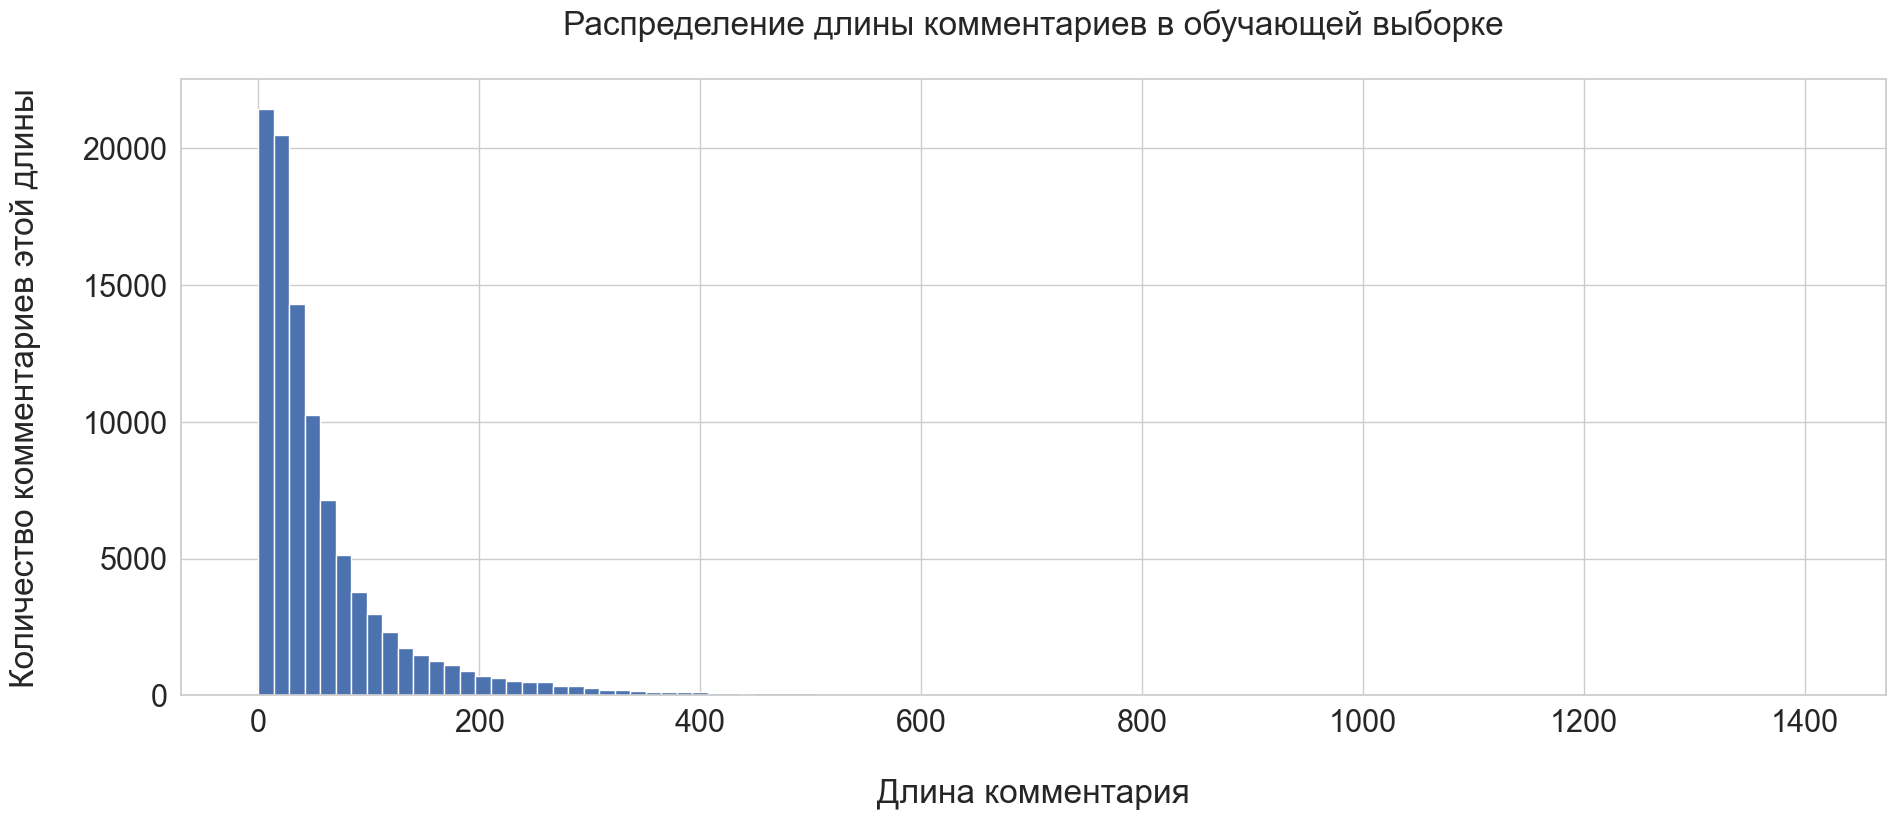

In [28]:
tmp = X_train.copy().reset_index()

tmp['len_text'] = [len(x.split()) for x in tmp['text']]

tmp['len_text'].hist(bins=100)
plt.xlabel('\nДлина комментария')
plt.ylabel(('Количество комментариев этой длины\n'))
plt.title('Распределение длины комментариев в обучающей выборке\n');

In [29]:
# выведем 95й перцентиль
tmp['len_text'].quantile(q=0.95)

234.0

In [30]:
print('Комментариев короче 250 слов:', round((tmp.loc[tmp['len_text'] < 250, 'text'].count() / len(tmp)) * 100 , 2), '%')

Комментариев короче 250 слов: 95.56 %


Таким образом, мы выяснили, что 95.5% комментариев в нашей обучающей выборке содержат менее 250 слов, при существовании максимума порядка 1400 слов. Поэтому, чтобы не потерять бОльшую часть информации, можно установить при токенизации параметр `max_length` на значение около 250 и по нему же провести паддинг. Все комментарии меньше 250 символов будут заполнены нулями до необходимой длины вектора.

Идея вот отсюда
https://raviteja-ganta.github.io/sentiment-analysis-using-bert-and-hugging-face

In [31]:
BATCH_SIZE = 256
MAX_LENGTH = 250

def make_embeddings(df, tokenizer, model, BATCH_SIZE, MAX_LENGTH):
    '''функция возвращает матрицу эмбеддингов'''  
    
    tokenized = df.apply(lambda x: tokenizer.encode(x,
                                                    add_special_tokens=True,
                                                    truncation=True,
                                                    max_length = MAX_LENGTH,
                                                    padding='max_length'))                                               
                         
    padded = np.array([i for i in tokenized.values])
    attention_mask = np.where(padded != 0, 1, 0)
    
    embeddings = []
    
    for i in notebook.tqdm(range(padded.shape[0] // BATCH_SIZE)):
        
        batch = torch.LongTensor(padded[BATCH_SIZE * i:BATCH_SIZE * (i + 1)]).to(DEVICE)
        attention_mask_batch = torch.LongTensor(attention_mask[BATCH_SIZE * i:BATCH_SIZE * (i + 1)]).to(DEVICE)
        with torch.no_grad():
            batch_embeddings = model(batch, attention_mask=attention_mask_batch)
        embeddings.append(batch_embeddings[0][:, 0, :].cpu().numpy())
        
        # тут обрабатывается последний неполный батч, так у меня зарботало, в других конфигурациях - нет
        # ЕСЛИ МОЖНО ПЕРЕПИСАТЬ КАК-ТО УМНЕЕ - ПОЖАЛУЙСТА, ДАЙ ПРИМЕР
        
        if i == (padded.shape[0] // BATCH_SIZE - 1):
            batch = torch.LongTensor(padded[BATCH_SIZE * (i + 1):]).to(DEVICE) 
            attention_mask_batch = torch.LongTensor(attention_mask[BATCH_SIZE * (i + 1):]).to(DEVICE)
            with torch.no_grad():
                batch_embeddings = model(batch, attention_mask=attention_mask_batch)
            embeddings.append(batch_embeddings[0][:, 0, :].cpu().numpy())
                
    return np.concatenate(embeddings)

Так как создание эмбеддингов это "дорогой" процесс, то сразу предобработаем обучающую и валидационную выборки и сохраним в отдельные переменные.

In [32]:
X_train_emb = make_embeddings(X_train, tokenizer, model, BATCH_SIZE, MAX_LENGTH)
X_train_emb.shape

  0%|          | 0/394 [00:00<?, ?it/s]

(101109, 768)

In [34]:
X_val_emb = make_embeddings(X_val, tokenizer, model, BATCH_SIZE, MAX_LENGTH)
X_val_emb.shape

  0%|          | 0/98 [00:00<?, ?it/s]

(25278, 768)

In [33]:
X_train_emb[0]

array([-0.50379705, -0.77239156,  0.6089041 , -0.5105705 ,  0.6855411 ,
        0.3193127 ,  0.20253448,  0.03993958, -0.3554938 , -0.6206508 ,
       -0.02825041, -0.7652708 ,  0.14689556, -0.87389106, -0.71847147,
        0.4962229 , -0.6028773 , -0.90095675, -0.34148705, -0.96424234,
        0.27579066, -0.9645777 ,  0.09303966, -0.00606825, -0.6645022 ,
       -0.6956932 , -0.54293287, -0.94595504, -0.5668362 ,  1.251306  ,
       -0.9608806 ,  1.0269117 ,  0.5244832 ,  0.8119951 ,  0.5488162 ,
        1.0428356 ,  0.781158  ,  0.2593397 ,  0.5996349 ,  0.8349321 ,
       -0.1327521 , -0.581208  ,  1.0088695 , -0.81871957,  0.02531149,
        0.79825705, -0.15790755, -1.1098845 , -1.4940871 , -0.89975554,
       -0.17426679,  0.88338464,  0.60156304,  0.9706179 , -0.7680654 ,
        0.6754315 , -0.328858  , -0.04363486, -0.66334087, -1.3420036 ,
       -0.7170368 , -0.91780823,  0.709899  ,  0.8058722 , -0.7374155 ,
        0.30518574, -0.7760307 ,  0.47923496, -0.16023628, -0.18

Таким образом, мы получили векторные представления размером 768, так как данная модель работает с такой размерностью эмбеддинга.

### Вспомогательные функции

In [34]:
# введем вспомогательные списки для занесения названия моделей, F1 для трейна и валидации

model_names = []
f1_scores_train = []
f1_scores_val = []

Для наглядного представления результатов обучения моделей классификации может быть полезно посмотреть на их матрицы ошибок, так как можно оценить какие метки модель определяет правильно (TP и TN), а в каких происходит мислейблинг (FP и FN).

In [35]:
def heatmap_confusion_matrix(preds, y_train):
    '''функция для построения тепловой карты по матрице ошибок модели'''
    
    ax = sns.heatmap(confusion_matrix(y_train, preds), annot=True, fmt='d', cmap='summer')
    
    ax.set_title('Матрица ошибок модели', fontdict={'fontsize':14})
    ax.set_xlabel('Предсказания модели', fontsize=14)
    ax.set_ylabel('Реальные значения таргета', fontsize=14)

Так как для каждой модели мы попробуем подобрать лучшие гиперпараметры, то напишем функцию, которая поможет нам осуществлять этот процесс с помощью GridSearchCV, получать и обрабатывать метрики, не копируя каждый раз большие куски кода, также введем функционал занесения этих метрик в датафрейм.

На вход функции вместе с моделью также будем подавать vectorizer и из этих этапов формировать единый Pipeline. Для эмбеддигов этот функционал уберем.

In [37]:
def get_metrics_gridsearch(model, name, 
                   params, vectorizer, 
                   features_train, target_train, 
                   features_val, target_val): 
    '''функция возвращает метрики, добавляет их в список и формирует датафрейм'''
    
    df_metrics = pd.DataFrame()
    
    if vectorizer in (count_tf_idf, count_ngram):
       
        # формируем пайплайн
        pipe = Pipeline([('vectorizer', vectorizer), ('model', model)])
    
        # поиск лучших гиперпараметров, оценка по f1
        search = GridSearchCV(estimator=pipe, 
                              param_grid=params, 
                              cv=5, 
                              n_jobs=-1, 
                              scoring='f1')
    else: 
        # те же процессы, но если внутрь подаются эмбеддинги (без пайплайна и с другими параметрами)
        search = GridSearchCV(model, 
                              param_grid=params, 
                              cv=5, 
                              n_jobs=-1, 
                              scoring='f1')
                         
    search.fit(features_train, target_train)   
   
    # лучшая модель
    best_estimator = search.best_estimator_
        
    # значение метрики
    f1_train = search.best_score_
    
    # делаем предсказание   
    pred_val = best_estimator.predict(features_val)
    f1_val = f1_score(target_val, pred_val, zero_division=0)
    
    # все результаты, в том числе модель 
    print('Лучшие гиперпараметры:', search.best_params_)
    print(f'Значение метрики F1 на тренировочной выборке {f1_train:.5f}'.format())
    print(f'Значение метрики F1 на валидационной выборке {f1_val:.5f}'.format())
    
     # заносим значения в датафрейм
    df_metrics['Модель'] = [name]
    df_metrics['F1_train'] = f1_train
    df_metrics['F1_val'] = f1_val
    
    # заносим значения в списки
    model_names.append(name)
    f1_scores_train.append(f1_train)
    f1_scores_val.append(f1_val)
    
    # heatmap матрицы ошибок на тесте
    heatmap_confusion_matrix(pred_val, target_val)
    
    return df_metrics

<div class="alert alert-block alert-success">
<b>Успех:</b> Молодец, что использовала пайплайн в этом шаге!
</div>

### Обучение моделей

В качестве классификаторов попробуем 4 модели:

- линейную LogisticRegression (логистическая регрессия),
- линейную SVC (метод опорных векторов для классификации),
- деревянную DecisionTree (Решающее дерево),
- бустинг LGBMClassiier.

Каждую модель будем пробовать как с обычным TfidfVectorizer, так создающим униграммы+биграммы, а также на эмбеддингах, полученных с помощью BERT. Там, где возможно, в моделях сразу пропишем параметр class_weight='balanced', так как у нас несбалансированные классы.

Все результаты выведем в виде датафрейма и визуализируем матрицами ошибок.

**ДИСКЛЕЙМЕР** Обучение моделей с поиском гиперпараметров могло занимать очень много времени, особенно на эмбеддингах, иногда процесс даже подвисал. Чтобы сократить требуемые вычислительные ресурсы и время проверки тетрадки, чаще всего я искала гиперпараметры на Tfidf, а при подаче эмбеддингов объявляла модель уже с этими найденными ранее гиперпараметрами. Надеюсь, так можно делать. Перебираемые гиперпраметры оставила в ячейках закомментированными, чтобы был виден ход мысли. 

#### LogisticRegression с поиском гиперпараметров.

In [45]:
log_reg = LogisticRegression(class_weight='balanced', random_state=RANDOM)

log_reg_params = {
            'model__penalty': ['l1', 'l2', 'elasticnet', 'none'],
            'model__C': [0.3, 0.5, 1, 3, 5],
            #'model__solver': ['liblinear', 'newton-cg', 'saga'],
            'model__max_iter': [500, 1000, 2000]
                 }

log_reg_params_emb = {}

# 'penalty': ['l1', 'l2', 'elasticnet', 'none'],
# 'C': [0.3, 0.5, 1, 3, 5],
# 'solver': ['liblinear', 'newton-cg', 'saga'],
# 'max_iter': [500, 1000, 2000]

Лучшие гиперпараметры: {'model__C': 3, 'model__max_iter': 500, 'model__penalty': 'l2'}
Значение метрики F1 на тренировочной выборке 0.73831
Значение метрики F1 на валидационной выборке 0.73578
CPU times: total: 1min 31s
Wall time: 5min 3s


,Модель,F1_train,F1_val
0,LogisticRegression_tfidf,0.738308,0.735781


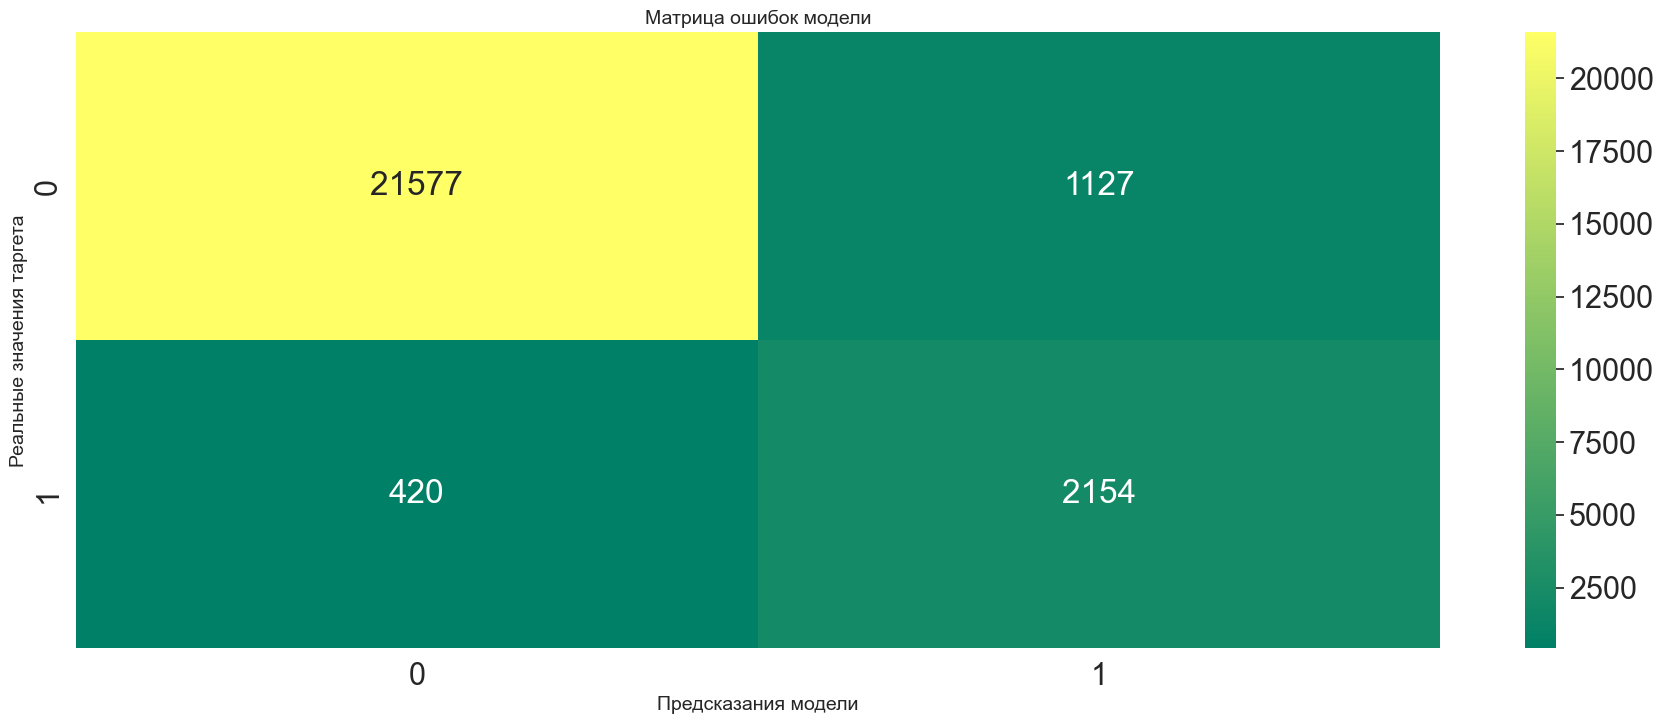

In [41]:
%%time

metrics = get_metrics_gridsearch(log_reg, 'LogisticRegression_tfidf', 
                                 log_reg_params, count_tf_idf, 
                                 X_train, y_train, X_val, y_val)
metrics

In [42]:
log_reg = LogisticRegression(class_weight='balanced', random_state=RANDOM)

Лучшие гиперпараметры: {'model__C': 3, 'model__max_iter': 500, 'model__penalty': 'l2'}
Значение метрики F1 на тренировочной выборке 0.72970
Значение метрики F1 на валидационной выборке 0.73446
CPU times: total: 1min 23s
Wall time: 10min 27s


,Модель,F1_train,F1_val
0,LogisticRegression_tfidf,0.738308,0.735781
0,LogisticRegression_ngram,0.729700,0.734458


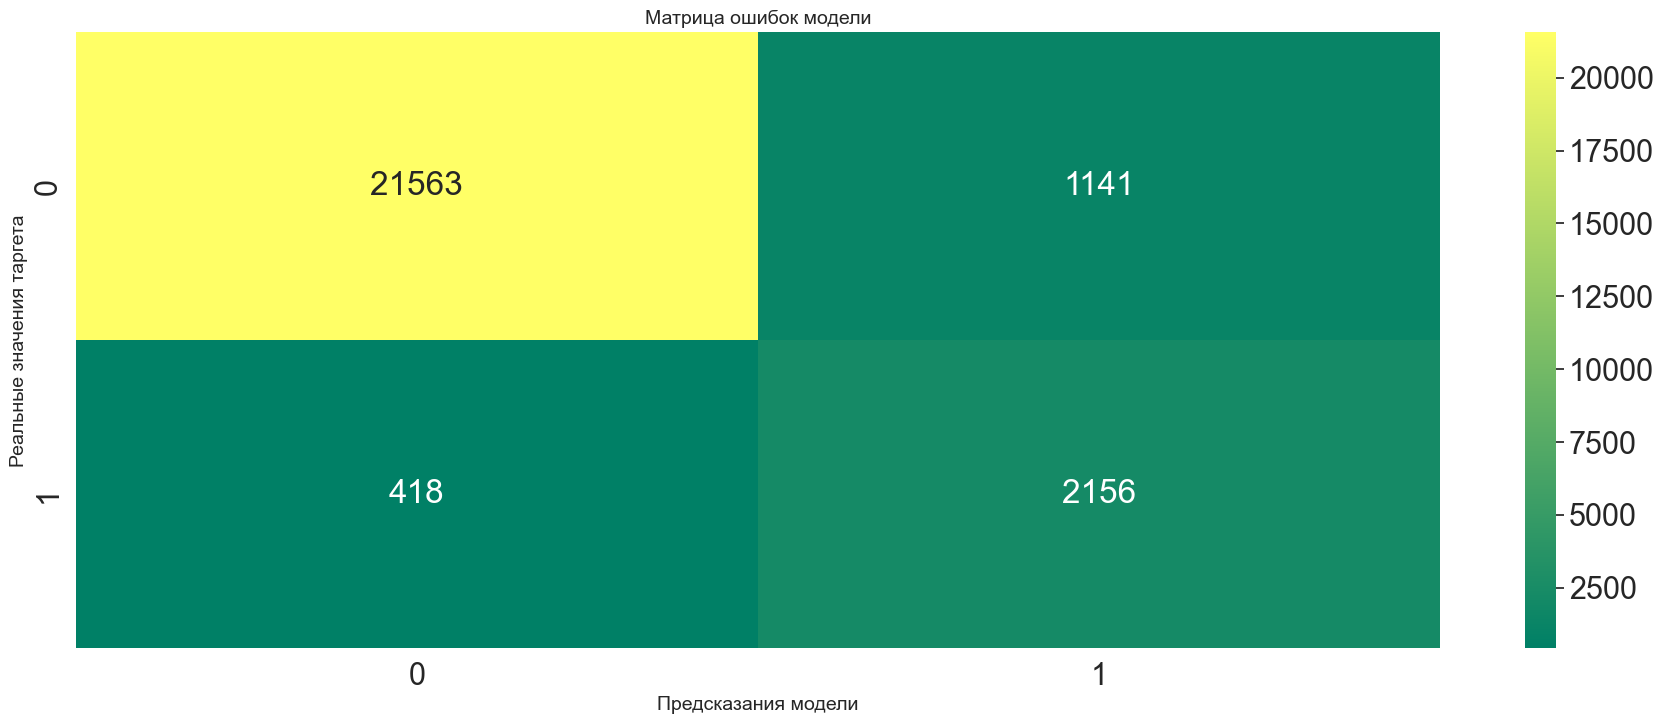

In [43]:
%%time

metrics_lr_gr = get_metrics_gridsearch(log_reg, 'LogisticRegression_ngram', 
                                 log_reg_params, count_ngram, 
                                 X_train, y_train, X_val, y_val)
metrics = metrics.append(metrics_lr_gr)
metrics

Лучшие гиперпараметры: {}
Значение метрики F1 на тренировочной выборке 0.86391
Значение метрики F1 на валидационной выборке 0.86162
CPU times: total: 2min 23s
Wall time: 1min 31s


,Модель,F1_train,F1_val
0,LogisticRegression_tfidf,0.738308,0.735781
0,LogisticRegression_ngram,0.729700,0.734458
0,LogisticRegression_embedding,0.863910,0.861624


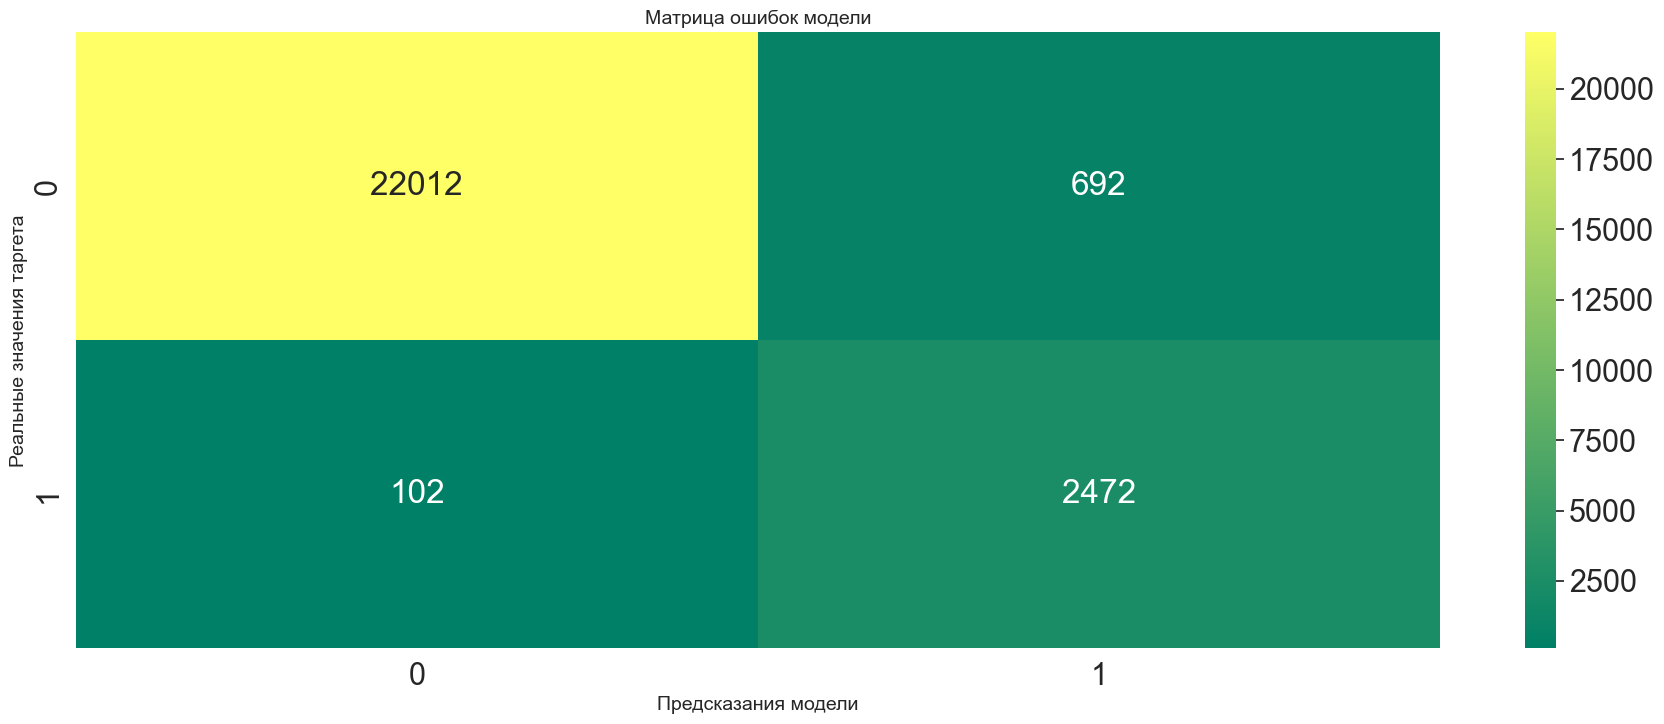

In [46]:
%%time

log_reg = LogisticRegression(class_weight='balanced', random_state=RANDOM, C=3, max_iter=500, penalty='l2')
metrics_lr_emb = get_metrics_gridsearch(log_reg, 'LogisticRegression_embedding', 
                                 log_reg_params_emb, None, 
                                 X_train_emb, y_train, X_val_emb, y_val)
metrics = metrics.append(metrics_lr_emb)
metrics

**Выводы**

- Логистическая регрессия успешно отработала на TfidfVectorizer, однако, пока на валидации не показала F1 выше 0.75. Разница между подходами без биграмм и с ними невелика.

- Лучшие параметры {'model__C': 3, 'model__max_iter': 500, 'model__penalty': 'l2'} мы передали в модель для оценки классификации на эмбеддингах. Результаты на эмбеддингах BERT кардинально отличаются - значение метрики достигло 0.86, то есть разница более одной десятой!

- Эти результаты хорошо видны на матрицах ошибок: модель лучше классифицирует эмбеддинги BERT, дает на них в 4 раза меньше False Negatives и в 2 раза меньше False Positives. 

#### LinearSVC  с поиском гиперпараметров.

In [47]:
svc = LinearSVC(random_state=RANDOM)

In [48]:
svc_params = {
            'model__C': [0.3, 0.5, 1, 3, 5],
            'model__max_iter': [500, 1000, 2000]
             }

svc_params_emb = {}

# 'C': [0.3, 0.5, 1, 3, 5],
# 'max_iter': [500, 1000, 2000]  

Лучшие гиперпараметры: {'model__C': 1, 'model__max_iter': 500}
Значение метрики F1 на тренировочной выборке 0.77397
Значение метрики F1 на валидационной выборке 0.77603
CPU times: total: 14.6 s
Wall time: 50.5 s


,Модель,F1_train,F1_val
0,LogisticRegression_tfidf,0.738308,0.735781
0,LogisticRegression_ngram,0.729700,0.734458
0,LogisticRegression_embedding,0.863910,0.861624
0,LinearSVC_tfidf,0.773969,0.776035


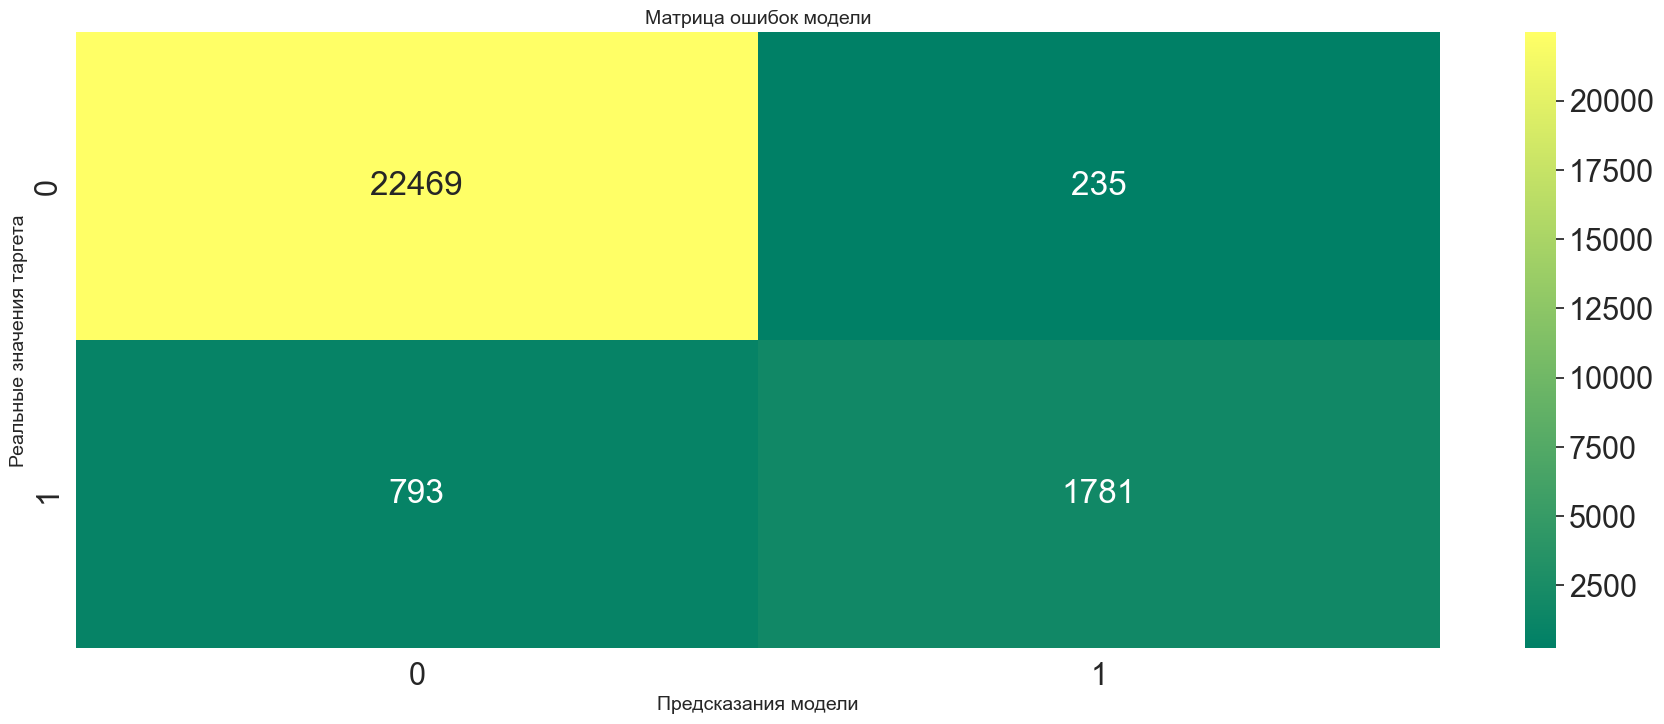

In [49]:
%%time

metrics_svc_tfidf = get_metrics_gridsearch(svc, 'LinearSVC_tfidf', 
                                 svc_params, count_tf_idf,
                                 X_train, y_train, X_val, y_val)
metrics = metrics.append(metrics_svc_tfidf)
metrics

Лучшие гиперпараметры: {'model__C': 1, 'model__max_iter': 500}
Значение метрики F1 на тренировочной выборке 0.76804
Значение метрики F1 на валидационной выборке 0.76539
CPU times: total: 24.2 s
Wall time: 2min 11s


,Модель,F1_train,F1_val
0,LogisticRegression_tfidf,0.738308,0.735781
0,LogisticRegression_ngram,0.729700,0.734458
0,LogisticRegression_embedding,0.863910,0.861624
0,LinearSVC_tfidf,0.773969,0.776035
0,LinearSVC_ngram,0.768045,0.765395


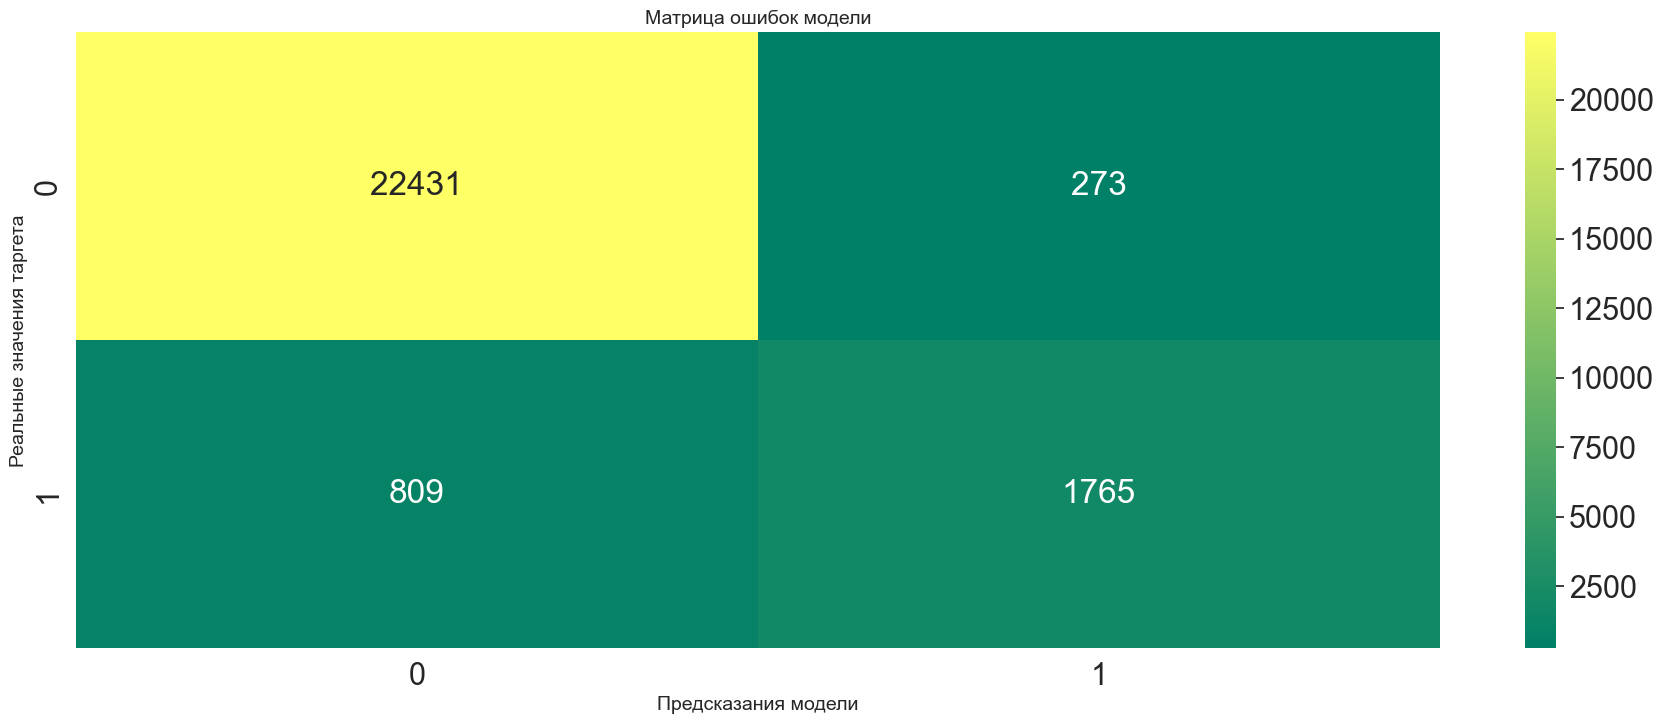

In [50]:
%%time

metrics_svc_gr = get_metrics_gridsearch(svc, 'LinearSVC_ngram', 
                                 svc_params, count_ngram, 
                                 X_train, y_train, X_val, y_val)
metrics = metrics.append(metrics_svc_gr)
metrics

Лучшие гиперпараметры: {}
Значение метрики F1 на тренировочной выборке 0.89875
Значение метрики F1 на валидационной выборке 0.89602
CPU times: total: 1min 1s
Wall time: 2min 10s


,Модель,F1_train,F1_val
0,LogisticRegression_tfidf,0.738308,0.735781
0,LogisticRegression_ngram,0.729700,0.734458
0,LogisticRegression_embedding,0.863910,0.861624
0,LinearSVC_tfidf,0.773969,0.776035
0,LinearSVC_ngram,0.768045,0.765395
0,LinearSVC_embedding,0.898749,0.896019


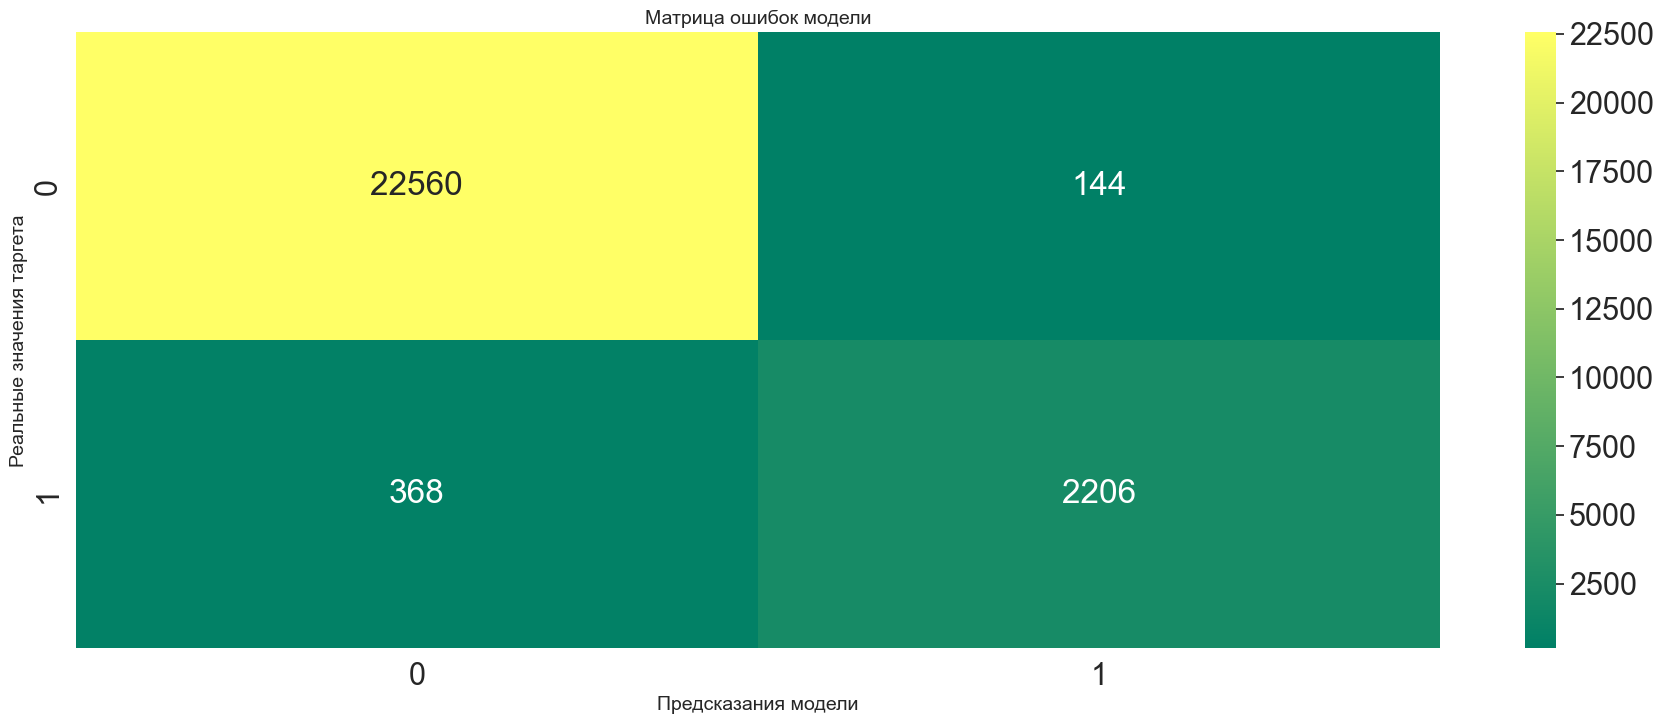

In [51]:
%%time

svc = LinearSVC(random_state=RANDOM, C=1, max_iter=500)
metrics_svc_emb = get_metrics_gridsearch(svc, 'LinearSVC_embedding', 
                                 svc_params_emb, None, 
                                 X_train_emb, y_train, X_val_emb, y_val)
metrics = metrics.append(metrics_svc_emb)
metrics

**Выводы**

- Машина опорных векторов на TfidfVectorizer показала на валидации F1 не ниже 0.76, то есть с ней мы уже проходим по порогу заказчика в 0.75. Разница между подходами без биграмм и с ними порядка 0.01.

- Лучшие параметры {'model__C': 1, 'model__max_iter': 500} передавались в модель для оценки классификации на эмбеддингах. Результаты на эмбеддингах BERT снова сильно превосходят подобные на TfidfVectorizer и превосходят логистическую регрессию на эмбеддингах - удалось получить значение F1-score=0.896. 

- По матрицам ошибок видно, что даже с tf-idf модель SVC лучше отделяет True Negative и False Positive, однако, испытывает больше проблем с FN и TP и чаще выдает False Negative. 

- Эмбеддинги BERT позволяют решать эту проблему, на валидации мы получили всего 368 False Negatives и 144 False Positive, что является отличным результатом и видно по высокому значению F1-score 0.896.

#### DecisionTree с поиском гиперпараметров.

In [52]:
dec_tree = DecisionTreeClassifier(random_state=RANDOM)

# объявляем перебираемые гиперпараметры
dec_tree_params = {
                'model__max_depth' : range(10, 21, 5),
                'model__min_samples_split' : range(5, 26, 5),
                'model__min_samples_leaf' : range(2, 12, 3)}

dec_tree_params_emb = {
                    'max_depth' : [10, 15, 20],
                    'min_samples_split' : [5, 10, 15, 25],
                    'min_samples_leaf' : [4, 8, 12]}

Лучшие гиперпараметры: {'model__max_depth': 20, 'model__min_samples_leaf': 11, 'model__min_samples_split': 25}
Значение метрики F1 на тренировочной выборке 0.66585
Значение метрики F1 на валидационной выборке 0.66667
CPU times: total: 53 s
Wall time: 4min 26s


,Модель,F1_train,F1_val
0,LogisticRegression_tfidf,0.738308,0.735781
0,LogisticRegression_ngram,0.729700,0.734458
0,LogisticRegression_embedding,0.863910,0.861624
0,LinearSVC_tfidf,0.773969,0.776035
0,LinearSVC_ngram,0.768045,0.765395
0,LinearSVC_embedding,0.898749,0.896019
0,DecisionTree_tfidf,0.665849,0.666667


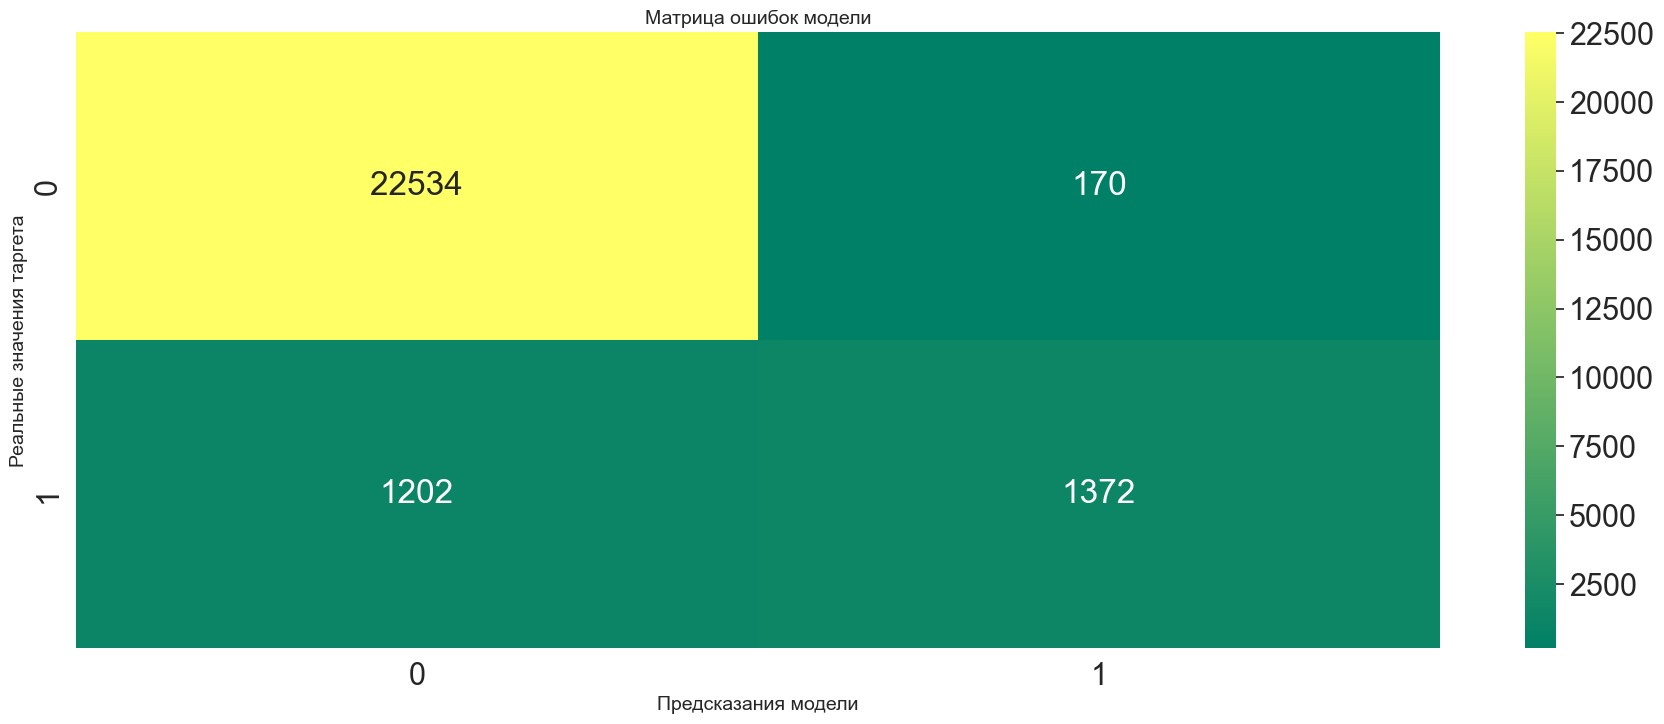

In [53]:
%%time

metrics_dec_tree_tfidf = get_metrics_gridsearch(dec_tree, 'DecisionTree_tfidf', 
                                 dec_tree_params, count_tf_idf,
                                 X_train, y_train, X_val, y_val)
metrics = metrics.append(metrics_dec_tree_tfidf)
metrics

Лучшие гиперпараметры: {'model__max_depth': 20, 'model__min_samples_leaf': 11, 'model__min_samples_split': 5}
Значение метрики F1 на тренировочной выборке 0.66666
Значение метрики F1 на валидационной выборке 0.66828
CPU times: total: 1min 5s
Wall time: 9min 13s


,Модель,F1_train,F1_val
0,LogisticRegression_tfidf,0.738308,0.735781
0,LogisticRegression_ngram,0.729700,0.734458
0,LogisticRegression_embedding,0.863910,0.861624
0,LinearSVC_tfidf,0.773969,0.776035
0,LinearSVC_ngram,0.768045,0.765395
0,LinearSVC_embedding,0.898749,0.896019
0,DecisionTree_tfidf,0.665849,0.666667
0,DecisionTree_ngram,0.666665,0.668280


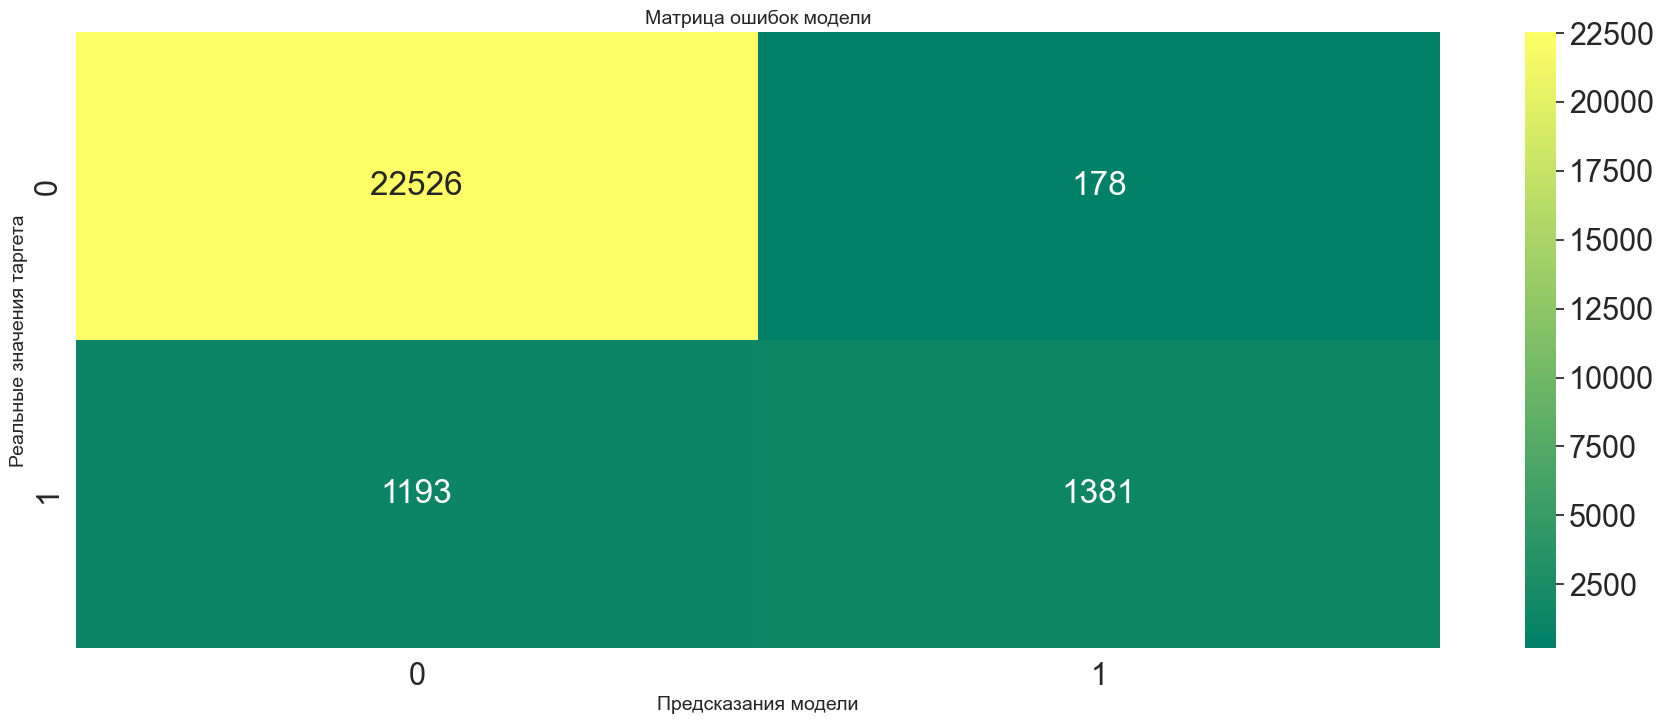

In [54]:
%%time

metrics_dec_tree_gr = get_metrics_gridsearch(dec_tree, 'DecisionTree_ngram', 
                                 dec_tree_params, count_ngram, 
                                 X_train, y_train, X_val, y_val)
metrics = metrics.append(metrics_dec_tree_gr)
metrics

Лучшие гиперпараметры: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 25}
Значение метрики F1 на тренировочной выборке 0.88118
Значение метрики F1 на валидационной выборке 0.87280
CPU times: total: 1min 15s
Wall time: 32min 19s


,Модель,F1_train,F1_val
0,LogisticRegression_tfidf,0.738308,0.735781
0,LogisticRegression_ngram,0.729700,0.734458
0,LogisticRegression_embedding,0.863910,0.861624
0,LinearSVC_tfidf,0.773969,0.776035
0,LinearSVC_ngram,0.768045,0.765395
0,LinearSVC_embedding,0.898749,0.896019
0,DecisionTree_tfidf,0.665849,0.666667
0,DecisionTree_ngram,0.666665,0.668280
0,DecisionTree_embedding,0.881181,0.872799


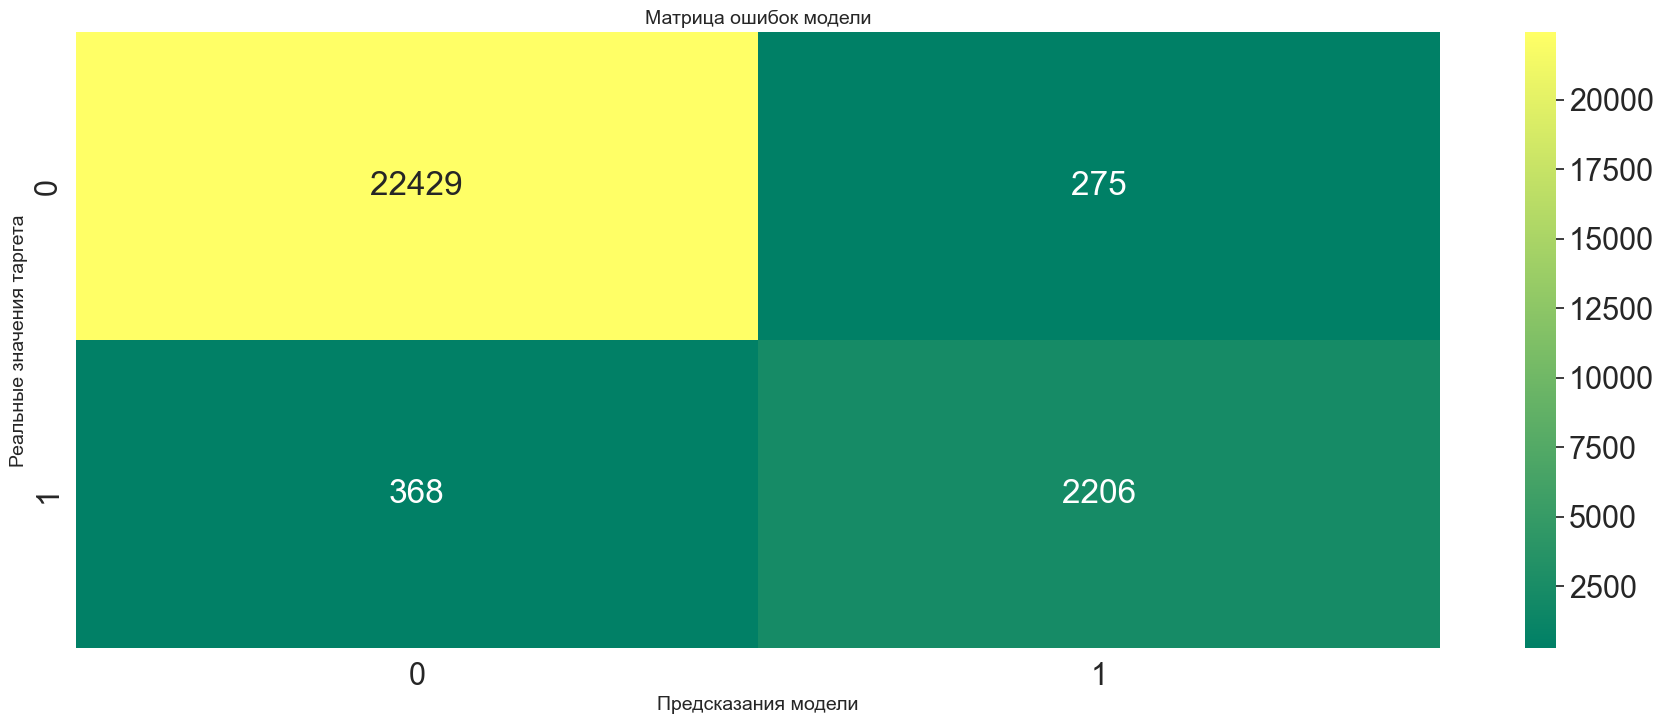

In [55]:
%%time

metrics_dec_tree_emb = get_metrics_gridsearch(dec_tree, 'DecisionTree_embedding', 
                                 dec_tree_params_emb, None, 
                                 X_train_emb, y_train, X_val_emb, y_val)
metrics = metrics.append(metrics_dec_tree_emb)
metrics

**Выводы**

- Решающее дерево на TfidfVectorizer показала на валидации пока самый низкий результат F1 - 0.66. Разницы между подходами без биграмм и с ними почти нет (тысячные).

- Лучшие параметры подбирлись независимо для всех моделей и несколько различаются, для модели работающей с эмбеддингами они получились такими {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 25}.

- Результаты на эмбеддингах BERT для Решающего дерева получились даже лучше, чем на логистической регрессии, F1-score составил для деревянной модели 0.87.

- Решающий лес показывает низний процент False Positive, но более тысячи значений для False Negative. 

- При применении эмбеддингов BERT  на матрице ошибок получаем результат близкий к таковому на SVC: 368 False Negatives и 275 False Positive. Таким образом, пока с эмбеддингами хуже всего метрика на логистической регрессии.

#### LGBMClassifier  с поиском гиперпараметров.

In [56]:
lgbm =  LGBMClassifier(random_state=RANDOM, class_weight='balanced')


lgbm_params = {
        #'model__num_leaves': [30, 40, 50],
        'model__learning_rate': [0.1, 0.3, 0.5],
        'model__n_estimators': [50, 100, 150],
        'model__max_depth': [10, 20, 30]
              }

lgbm_params_emb = {
            #'num_leaves': [10, 30, 50],
            'learning_rate': [0.1, 0.2, 0.5],
            'n_estimators': [50, 100, 150],
            'max_depth': [10, 20, 30]
                  }

Лучшие гиперпараметры: {'model__learning_rate': 0.3, 'model__max_depth': 20, 'model__n_estimators': 150}
Значение метрики F1 на тренировочной выборке 0.75327
Значение метрики F1 на валидационной выборке 0.75845
CPU times: total: 2min 38s
Wall time: 8min 26s


,Модель,F1_train,F1_val
0,LogisticRegression_tfidf,0.738308,0.735781
0,LogisticRegression_ngram,0.729700,0.734458
0,LogisticRegression_embedding,0.863910,0.861624
0,LinearSVC_tfidf,0.773969,0.776035
0,LinearSVC_ngram,0.768045,0.765395
0,LinearSVC_embedding,0.898749,0.896019
0,DecisionTree_tfidf,0.665849,0.666667
0,DecisionTree_ngram,0.666665,0.668280
0,DecisionTree_embedding,0.881181,0.872799
0,LGBMClassifier_tfidf,0.753268,0.758446


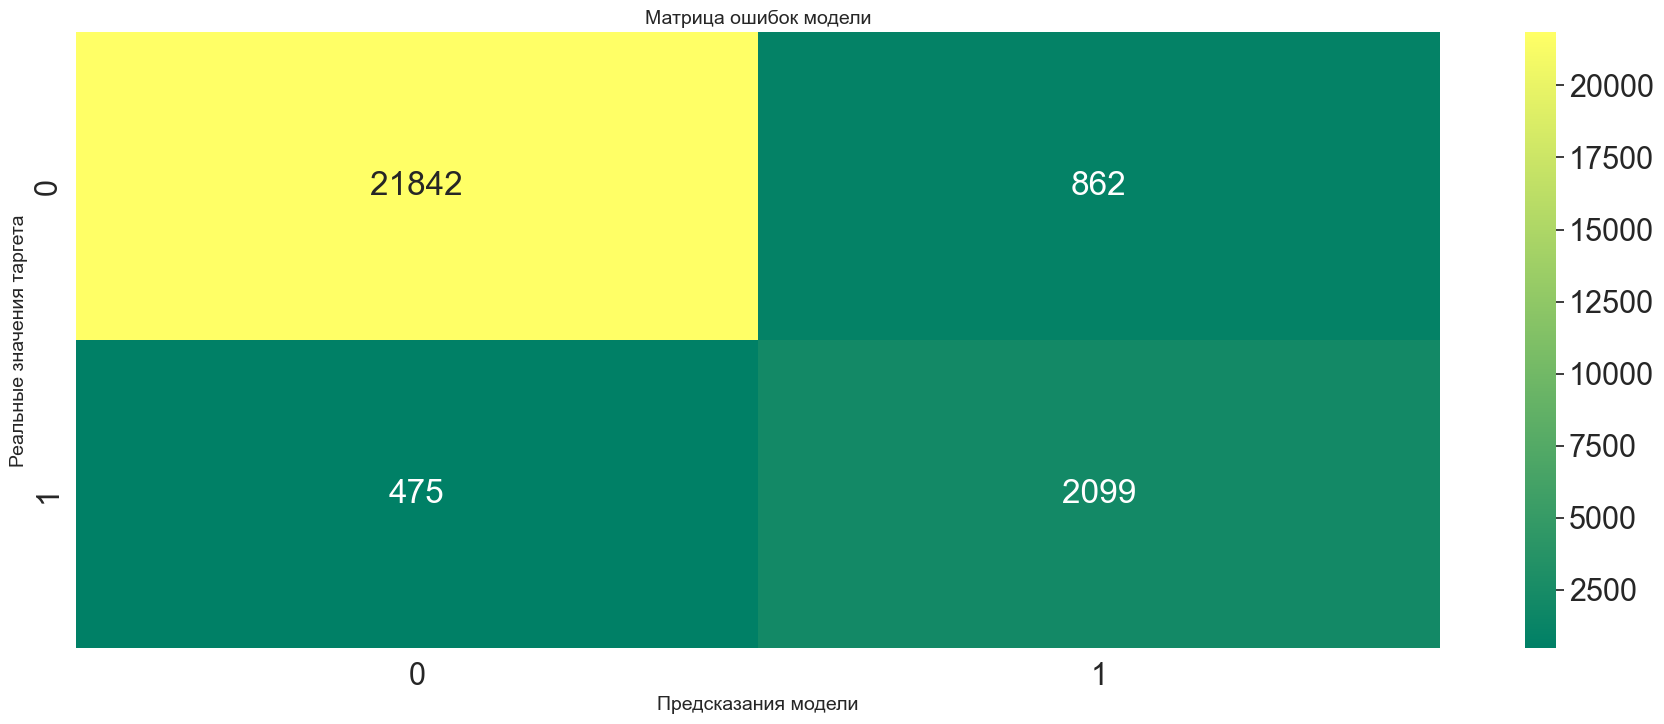

In [57]:
%%time

metrics_lgbm_tfidf = get_metrics_gridsearch(lgbm, 'LGBMClassifier_tfidf', 
                                 lgbm_params, count_tf_idf,
                                 X_train, y_train, X_val, y_val)
metrics = metrics.append(metrics_lgbm_tfidf)
metrics

Лучшие гиперпараметры: {'model__learning_rate': 0.3, 'model__max_depth': 20, 'model__n_estimators': 150}
Значение метрики F1 на тренировочной выборке 0.75057
Значение метрики F1 на валидационной выборке 0.75004
CPU times: total: 3min 55s
Wall time: 14min 7s


,Модель,F1_train,F1_val
0,LogisticRegression_tfidf,0.738308,0.735781
0,LogisticRegression_ngram,0.729700,0.734458
0,LogisticRegression_embedding,0.863910,0.861624
0,LinearSVC_tfidf,0.773969,0.776035
0,LinearSVC_ngram,0.768045,0.765395
0,LinearSVC_embedding,0.898749,0.896019
0,DecisionTree_tfidf,0.665849,0.666667
0,DecisionTree_ngram,0.666665,0.668280
0,DecisionTree_embedding,0.881181,0.872799
0,LGBMClassifier_tfidf,0.753268,0.758446


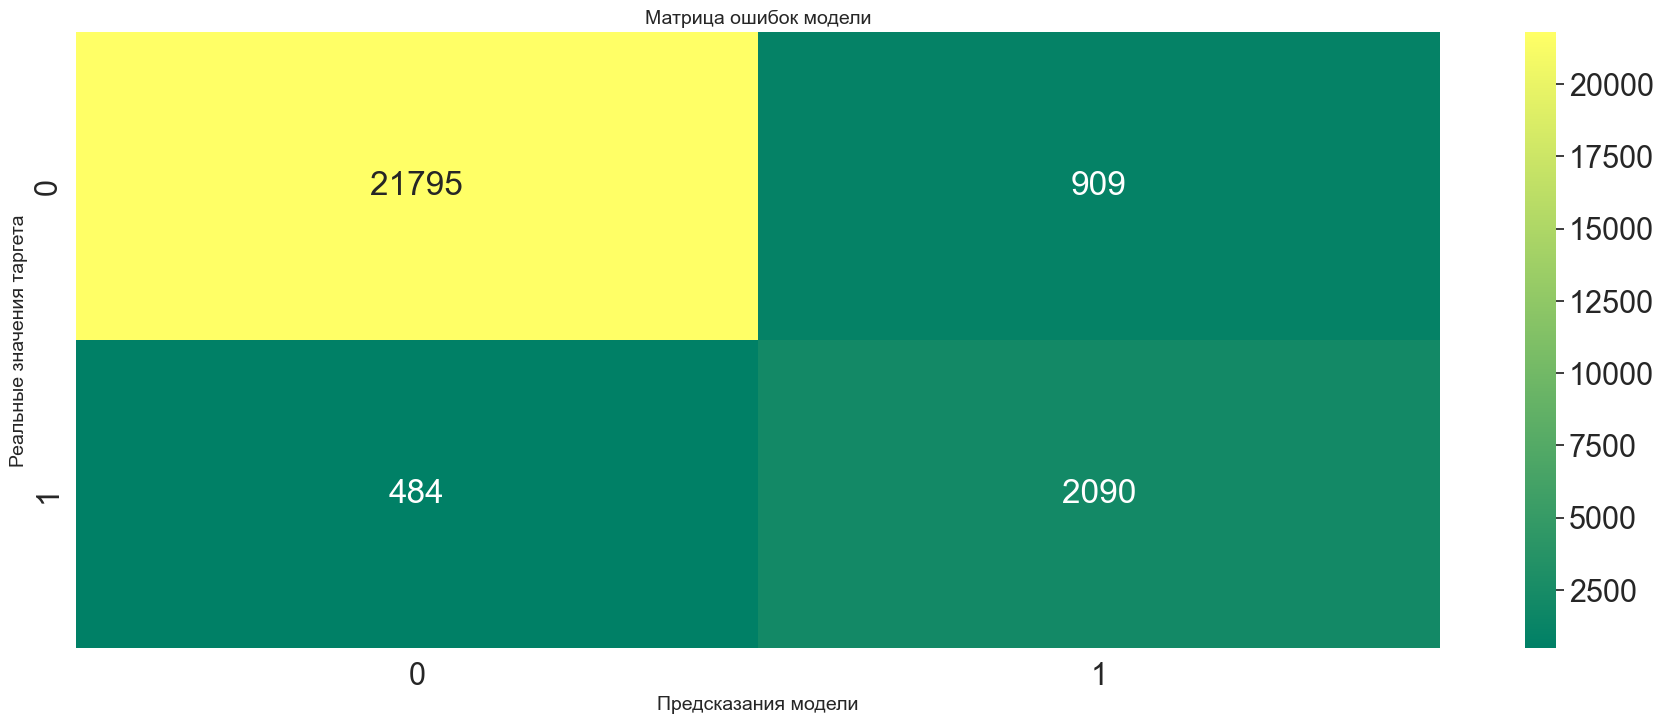

In [58]:
%%time

metrics_lgbm_gr = get_metrics_gridsearch(lgbm, 'LGBMClassifier_ngram', 
                                 lgbm_params, count_ngram, 
                                 X_train, y_train, X_val, y_val)
metrics = metrics.append(metrics_lgbm_gr)
metrics

Лучшие гиперпараметры: {'learning_rate': 0.2, 'max_depth': 10, 'n_estimators': 150}
Значение метрики F1 на тренировочной выборке 0.89612
Значение метрики F1 на валидационной выборке 0.88691
CPU times: total: 2min 5s
Wall time: 10min 4s


,Модель,F1_train,F1_val
0,LogisticRegression_tfidf,0.738308,0.735781
0,LogisticRegression_ngram,0.729700,0.734458
0,LogisticRegression_embedding,0.863910,0.861624
0,LinearSVC_tfidf,0.773969,0.776035
0,LinearSVC_ngram,0.768045,0.765395
0,LinearSVC_embedding,0.898749,0.896019
0,DecisionTree_tfidf,0.665849,0.666667
0,DecisionTree_ngram,0.666665,0.668280
0,DecisionTree_embedding,0.881181,0.872799
0,LGBMClassifier_tfidf,0.753268,0.758446


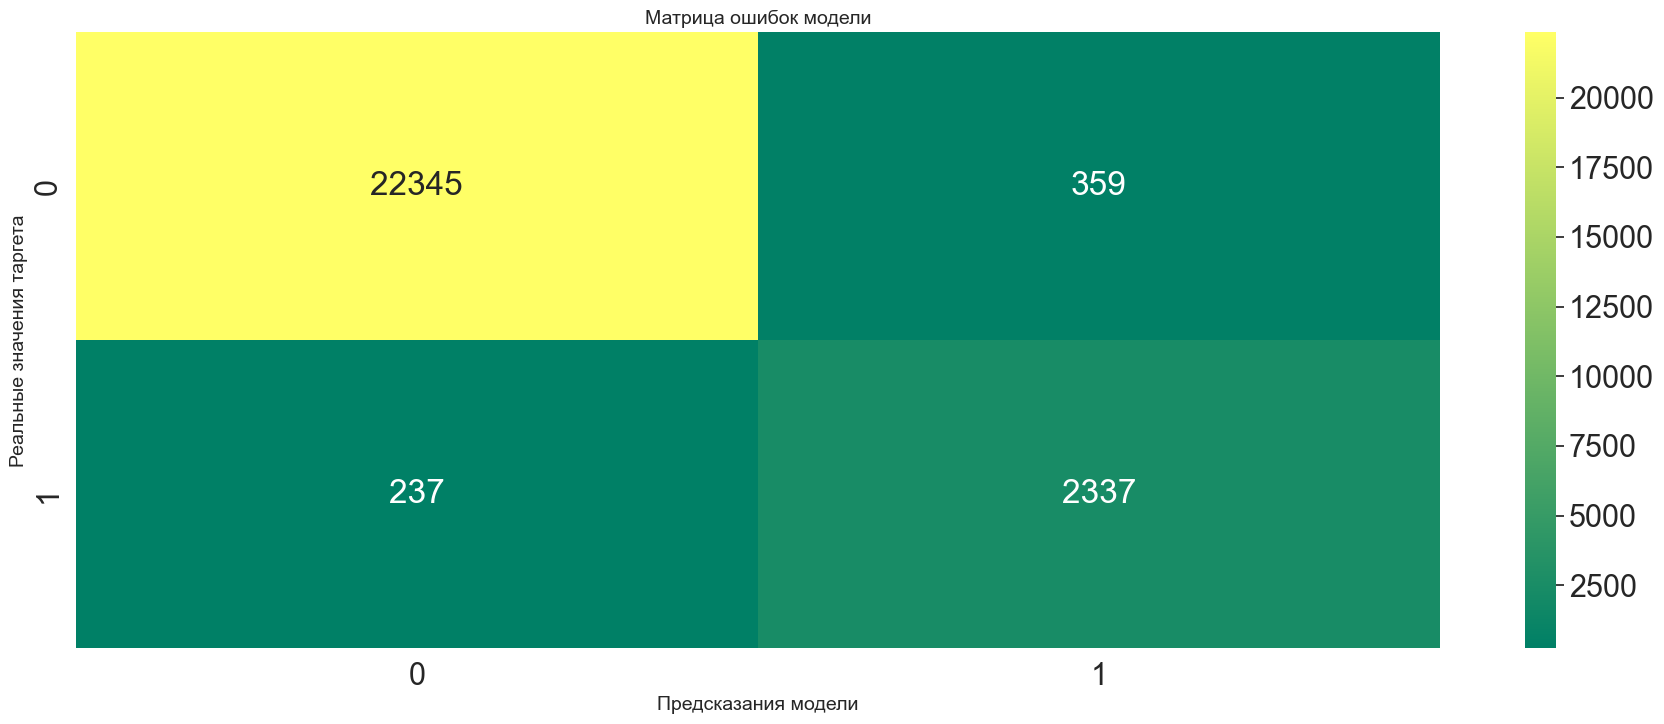

In [59]:
%%time

metrics_lgbm_emb = get_metrics_gridsearch(lgbm, 'LGBMClassifier_embedding', 
                                 lgbm_params_emb, None, 
                                 X_train_emb, y_train, X_val_emb, y_val)
metrics = metrics.append(metrics_lgbm_emb)
metrics

**Выводы**

- Бустинговая модель LGBMClassifier на TfidfVectorizer не смогла по F1 обогнать линейный SVC, но уверенно обошла другие модели. Однако, мы получили граничное к нашим требованиям значение метрики на валидации 0.758, что означает, что ее можно было бы попробовать использовать при тестировании. Разница между подходами без биграмм и с ними около 8 тысячных.

- Лучшие параметры подбирались независимо для всех моделей и несколько различаются, для модели работающей с эмбеддингами они получились такими {'learning_rate': 0.2, 'max_depth': 10, 'n_estimators': 150}.

- Результаты на эмбеддингах BERT выше, чем для Логистической регрессии и Решающего дерева, но ниже, чем для SVC.

- LGBM хорошо различает True Positive и False Negative, но хуже, чем SVC работает с True Negative и False Positive.

### Анализ моделей

Для удобства анализа визуализируем распределение целевой метрики F1-score в разрезе моделей от наименьшей к наибольшей с помощью барплотов.

Сделаем общий план, а затем разобьем по типу векторизации.

In [60]:
metrics.set_index('Модель', inplace=True)

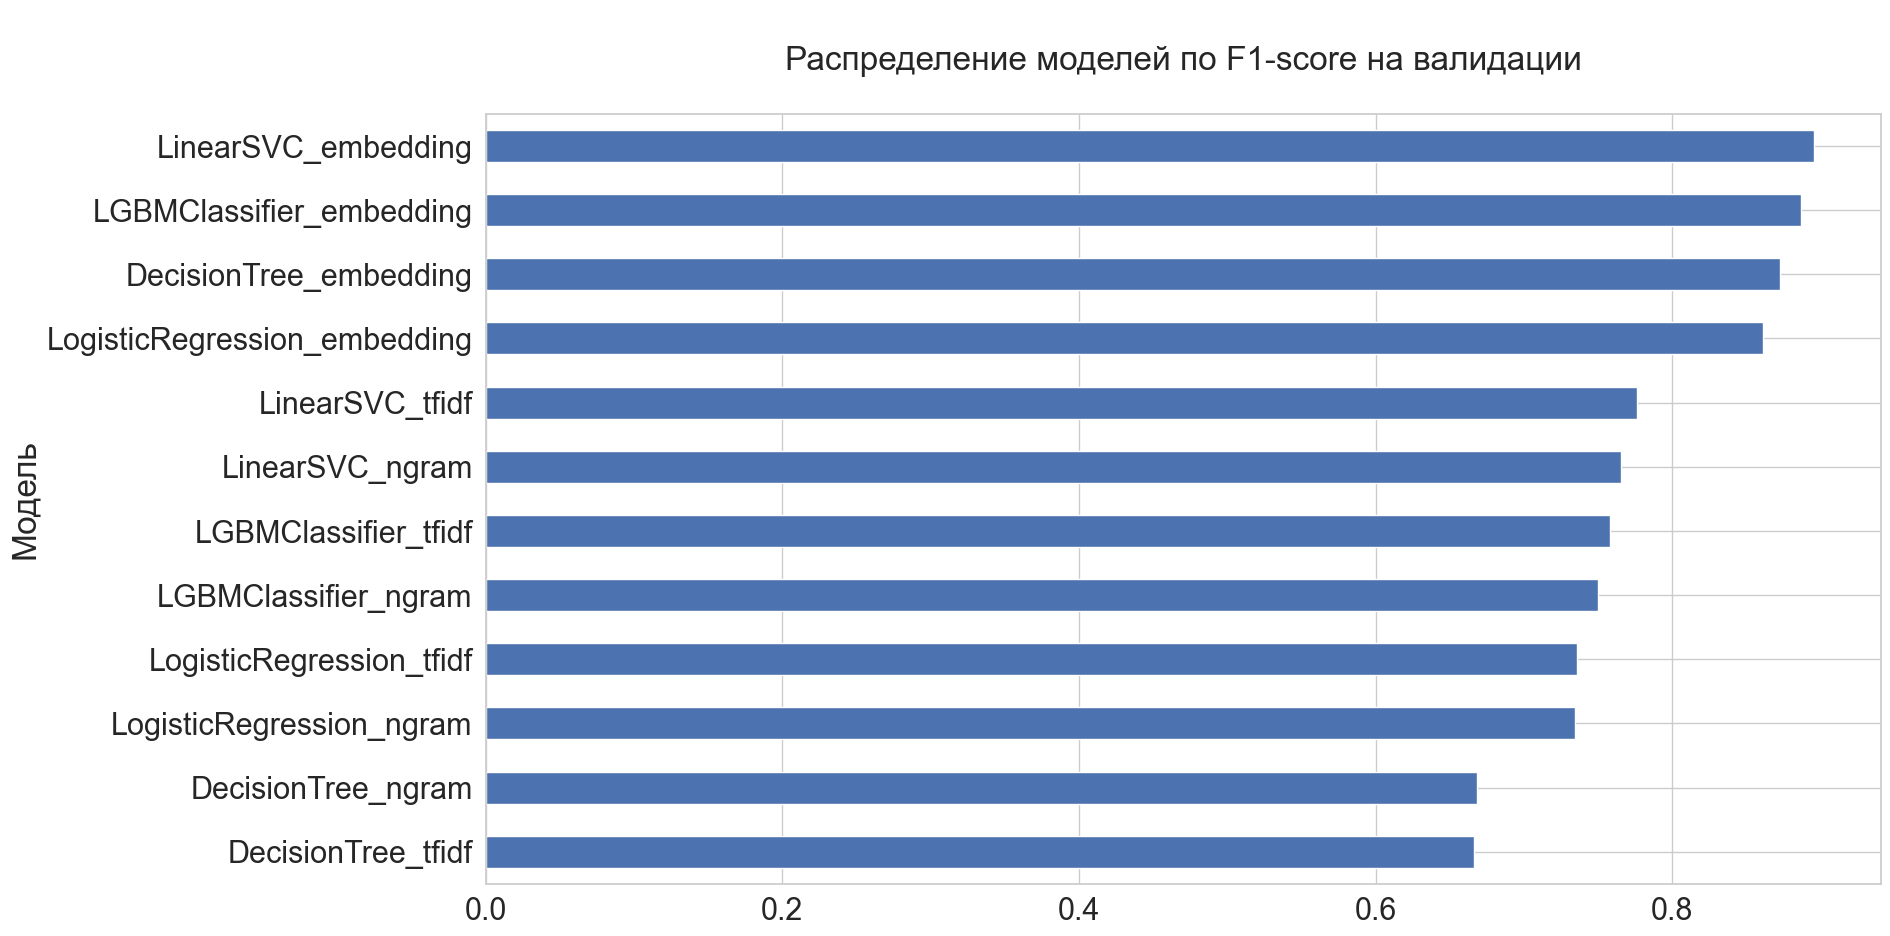

In [65]:
metrics.sort_values(by='F1_val')['F1_val'].plot(kind='barh', 
                                                title=f'\nРаспределение моделей по F1-score на валидации\n', 
                                                figsize=(18, 10));

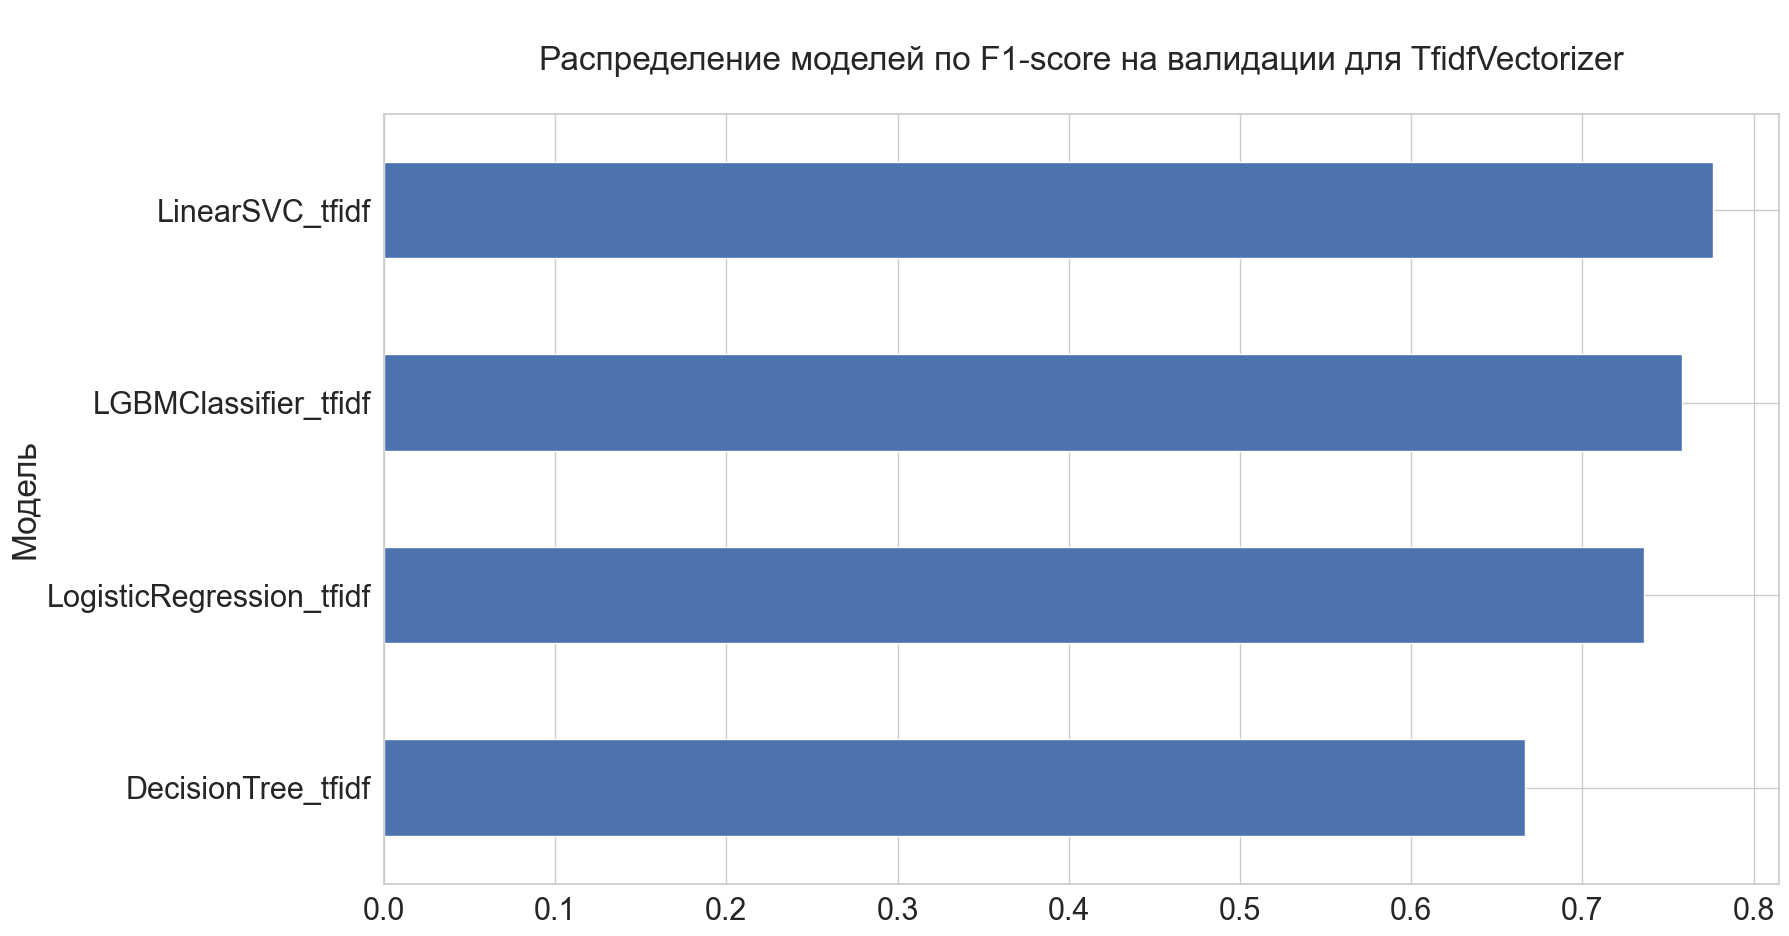

In [79]:
metrics.loc[[name for name in metrics.index if name.endswith('tfidf')], 'F1_val'].sort_values()\
       .plot(kind='barh', 
             title=f'\nРаспределение моделей по F1-score на валидации для TfidfVectorizer\n', 
             figsize=(18, 10));

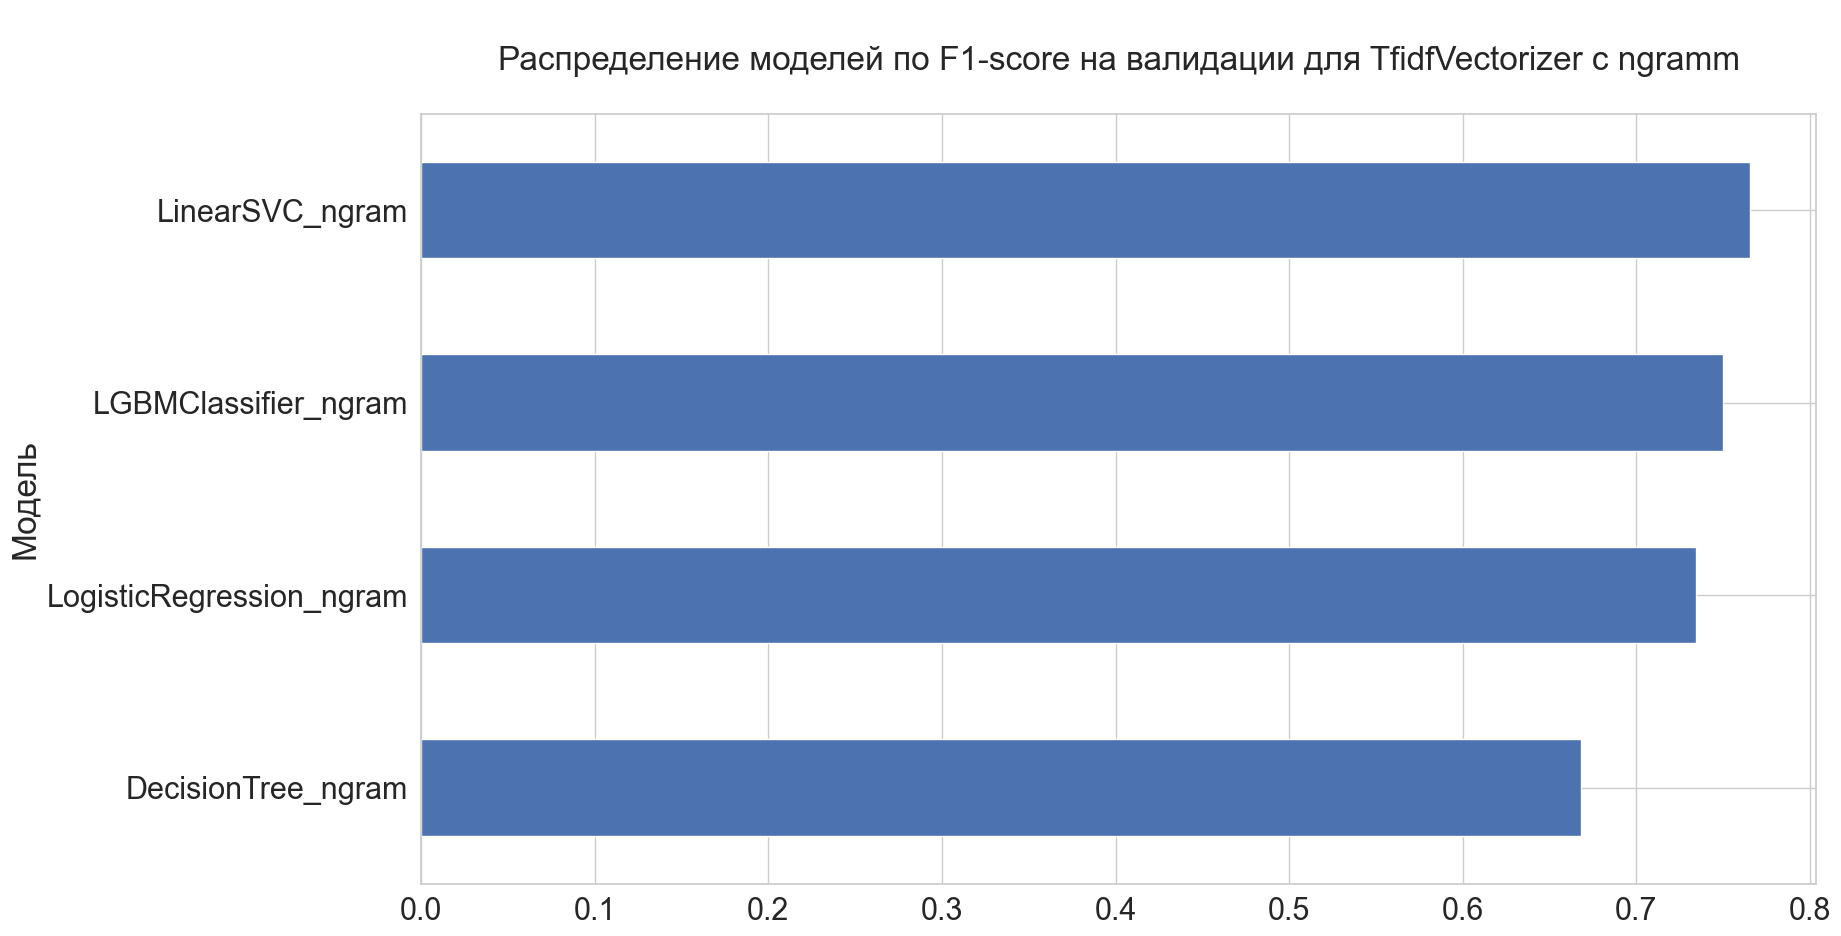

In [80]:
metrics.loc[[name for name in metrics.index if name.endswith('ngram')], 'F1_val'].sort_values()\
       .plot(kind='barh', 
             title=f'\nРаспределение моделей по F1-score на валидации для TfidfVectorizer с ngramm\n', 
             figsize=(18, 10));

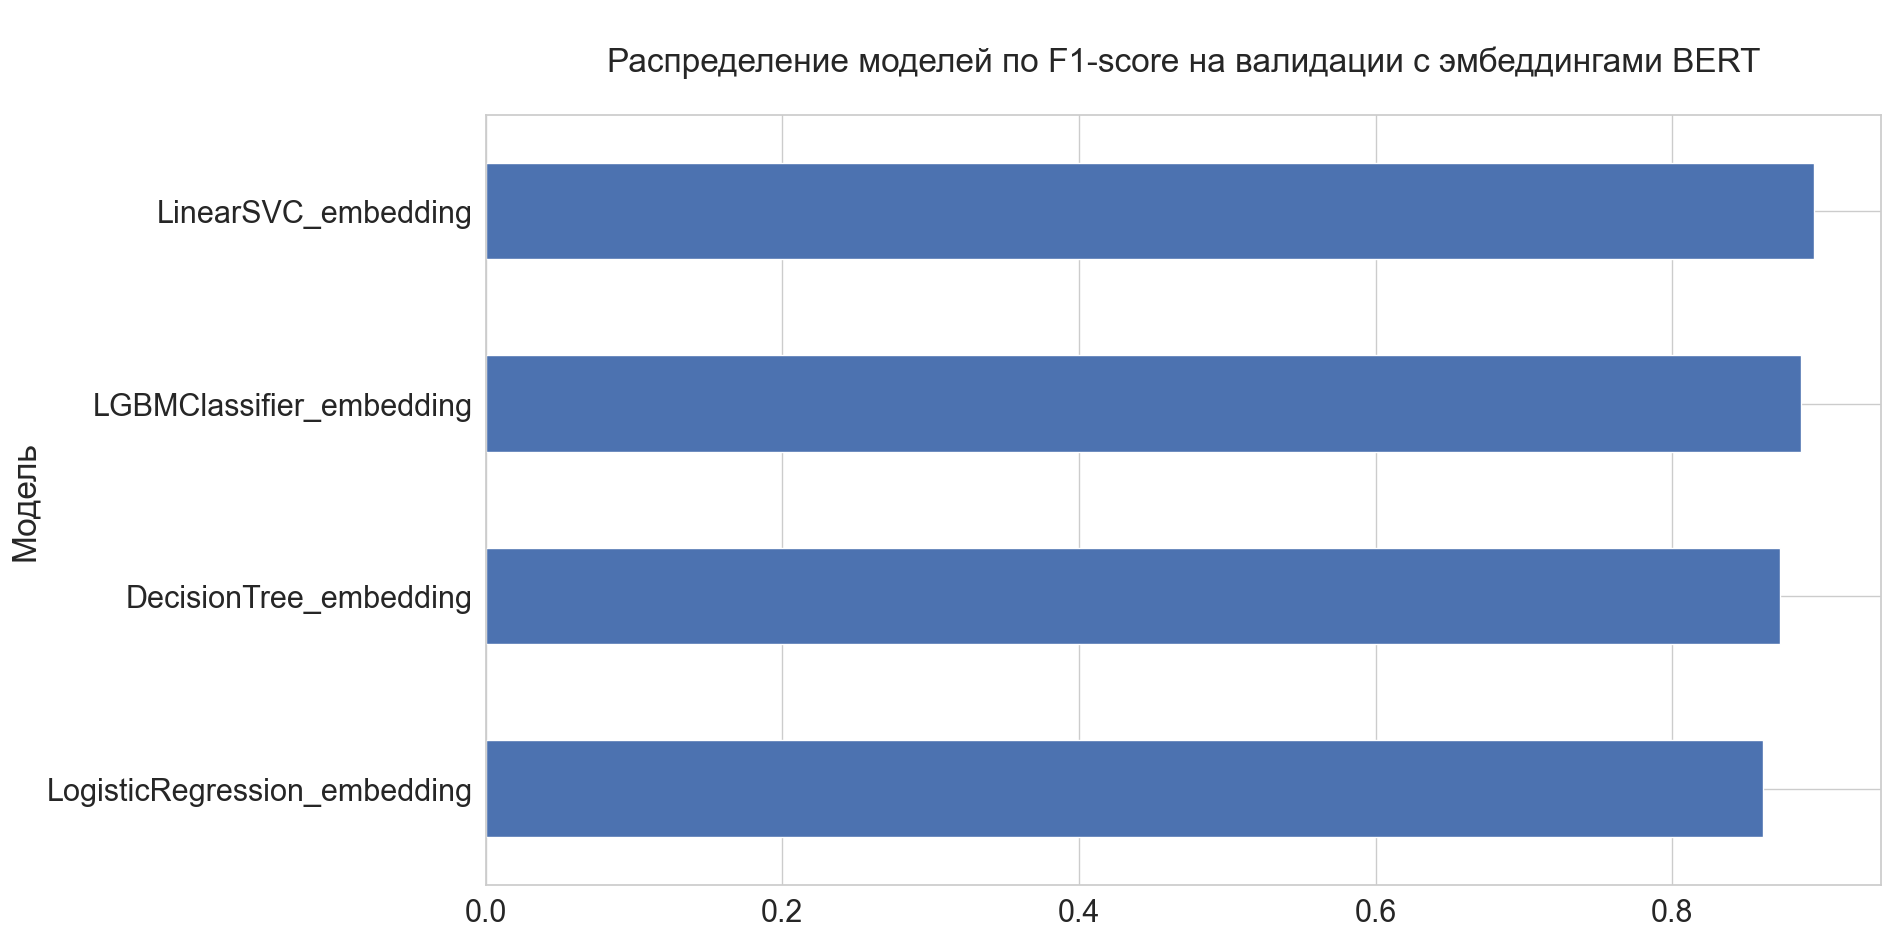

In [81]:
metrics.loc[[name for name in metrics.index if name.endswith('embedding')], 'F1_val'].sort_values()\
       .plot(kind='barh', 
             title=f'\nРаспределение моделей по F1-score на валидации с эмбеддингами BERT\n', 
             figsize=(18, 10));

**Выводы**


- Лучший F1-score по результатам ВСЕХ испытаний показал LinearSVC(random_state=RANDOM, C=1, max_iter=500), обученный на эмбеддингах BERT (F1-score=0.896). Незначительно хуже LGBMClassifier (F1-score=0.8869) и DecisionTree (F1-score=0.8728) также на эмбеддингах. Самые плохие результаты показал DecisionTree на TfidfVectorizer (F1-score=0.6667).


- Результаты на эмбеддингах ПРИНЦИПИАЛЬНО отличаются от результатов всех моделей на TfidfVectorizer.


- Среди эмбеддинговых лучше всего модель LinearSVC, хуже всего логистическая регрессия, однако, разность принципиально невелика, всего порядка 0.034.


- Из моделей, обученных с применением TfidfVectorizer распределение по метрике F1 не завиит от того, обучались мы только на самих словах, или униграммах и биграммах вместе. Лучше всего с классификацией справляется также LinearSVC (F1-score=0.776), на втором месте LGBMClassifier с F1-score=0.758, далее логистическая регрессия (F1-score=0.7357) и замыкает рейтинг Решающее дерево с показателем метрики в районе 0.66.

### Выводы по разделу

Перед непосредствено процессо обучения мы 

- произвели разделение выборок,
- задали способы превращения текстовой информации в векторное представление,
- написали функции для сбора и визуализации метрик и поиска гиперпараметров через GridSearchCV.

Далее обучили 4 модели:
    
- линейную LogisticRegression (логистическая регрессия),
- линейную SVC (метод опорных векторов для классификации),
- деревянную DecisionTree (Решающее дерево),
- бустинг LGBMClassiier.

Каждую модель попробовали как с обычным TfidfVectorizer, так и создающим униграммы+биграммы, а также на эмбеддингах, полученных с помощью BERT.
Все результаты вывели в виде датафрейма и визуализировали матрицы ошибок для их интерпретации.

Далее нами были проанализированы все результаты и представлены визуально в виде барплотов. 

По результатам сравнительного анализа для финального тестирования я рекомендую остановиться на LinearSVC с подобранными лучшими гиперпараметрами и обучением на эмбеддингах BERT, так как значение метрики F1 на валидации составило 0.8869, что позволяет нам рассчитывать на хороший результат и на отложенной тестовой выборке. 

## Тестирование лучшей модели

Подготовим векторное представление текстов из тестовой выборки.

In [84]:
X_test_emb = make_embeddings(X_test, tokenizer, model, BATCH_SIZE, MAX_LENGTH)
X_test_emb.shape

  0%|          | 0/61 [00:00<?, ?it/s]

(31597, 768)

Зададим выбранную модель с лучшими гиперпараметрами, передадим ей эмбеддинги и получим метрику F1-score для лучшей модели на тестовой выборке.

Метрика F1-score для лучшей модели на тестовой выборке: 0.9028184198367472


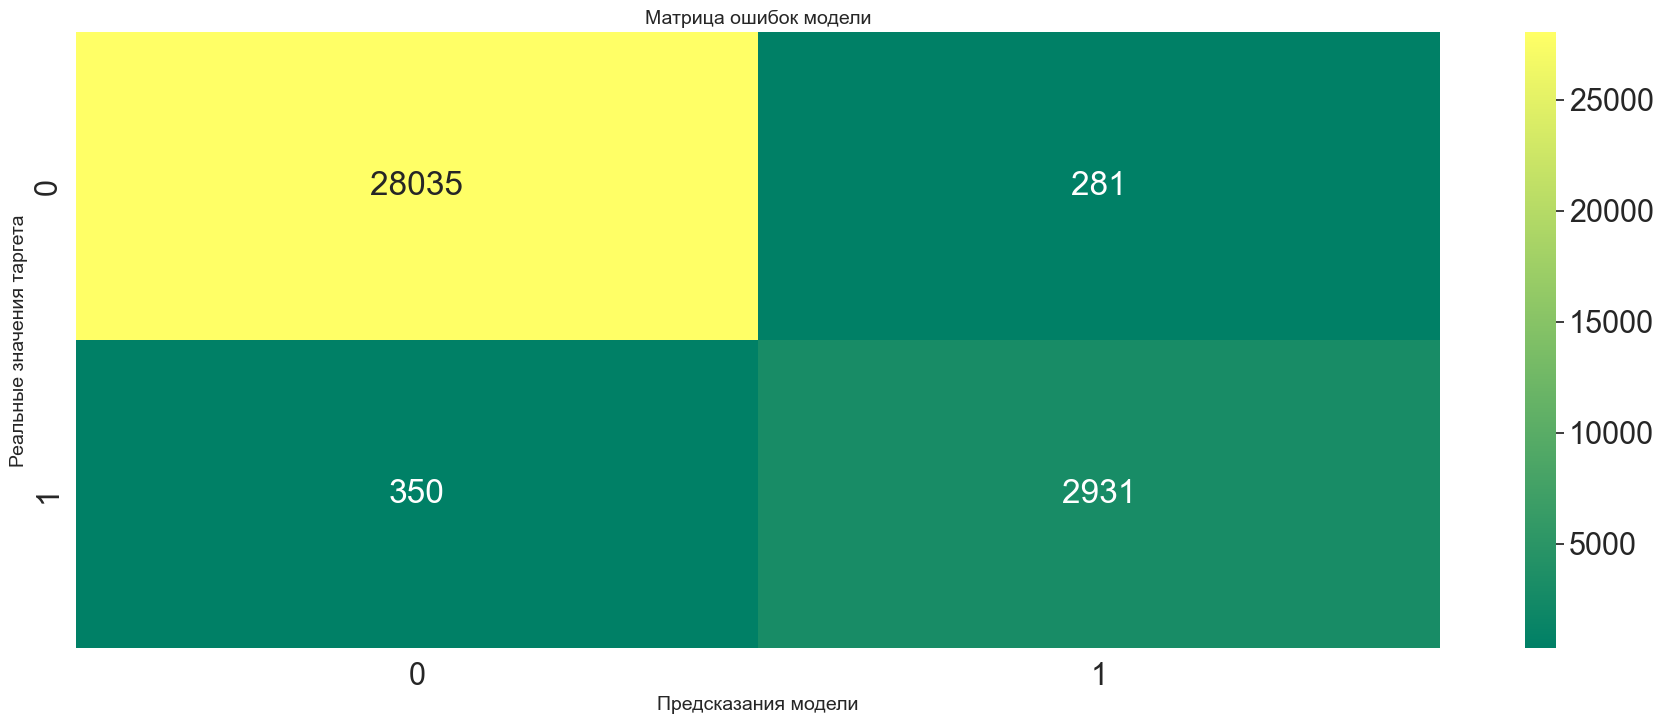

In [122]:
best_model = LinearSVC(random_state=RANDOM, class_weight='balanced', C=1, max_iter=500, penalty='l2')

best_model.fit(X_train_emb, y_train)
preds = best_model.predict(X_test_emb)
best_model_f1 = f1_score(y_test, preds)

print(f'Метрика F1-score для лучшей модели на тестовой выборке: {best_model_f1}')

heatmap_confusion_matrix(y_test, preds)

Таким образом, мы получили значение F1-score=0.90, что подходит под критерии заказчика.

В завершение хотела бы наглядно представить самые распространенные слова в слова в токсичных и нетоксичных текстах датасета с помощью графика WordCloud.

In [174]:
MAX_WORDS = 150 # будем использовать самые распространенные слова

comments_toxic = comments[comments['toxic']==1]
comments_nontoxic = comments[comments['toxic']==0]

In [175]:
count_vectorizer_t = CountVectorizer(max_features=MAX_WORDS, stop_words="english")
count_vectorizer_nt = CountVectorizer(max_features=MAX_WORDS, stop_words="english")

In [176]:
sparce_matrix_toxic = count_vectorizer_t.fit_transform(comments_toxic.text).toarray()
print(f"Самые употребляемые {MAX_WORDS} слов в токсичных комментариях\n {count_vectorizer_t.get_feature_names()}")

Самые употребляемые 150 слов в токсичных комментариях
 ['add', 'admin', 'aids', 'article', 'ass', 'asshole', 'attack', 'bad', 'ball', 'ban', 'bark', 'bastard', 'big', 'bitch', 'block', 'bullshit', 'bush', 'buttsecks', 'care', 'change', 'cock', 'cocksucker', 'come', 'comment', 'cunt', 'damn', 'day', 'delete', 'dick', 'dickhead', 'didn', 'die', 'doesn', 'dog', 'don', 'dont', 'dumb', 'eat', 'edit', 'editor', 'fact', 'fag', 'faggot', 'fat', 'fggt', 'fool', 'freedom', 'fuck', 'fucker', 'fucking', 'fucksex', 'gay', 'god', 'good', 'guy', 'hate', 'hell', 'hey', 'hi', 'hitler', 'homo', 'hope', 'huge', 'idiot', 'information', 'jew', 'just', 'kill', 'know', 'leave', 'let', 'lick', 'lie', 'life', 'like', 'little', 'live', 'll', 'look', 'loser', 'love', 'make', 'man', 'mean', 'moron', 'mother', 'mothjer', 'need', 'new', 'nigger', 'nipple', 'noobs', 'oh', 'old', 'page', 'penis', 'people', 'person', 'personal', 'piece', 'pig', 'poop', 'post', 'pro', 'pussy', 'rape', 'read', 'real', 'really', 'reason'

In [177]:
sparce_matrix_nontoxic = count_vectorizer_nt.fit_transform(comments_nontoxic.text).toarray()
print(f"Самые употребляемые {MAX_WORDS} слов в нетоксичных комментариях\n {count_vectorizer_nt.get_feature_names()}")

Самые употребляемые 150 слов в нетоксичных комментариях
 ['account', 'actually', 'add', 'admin', 'agree', 'appear', 'article', 'ask', 'attack', 'believe', 'block', 'book', 'case', 'change', 'check', 'cite', 'claim', 'com', 'come', 'comment', 'consider', 'content', 'continue', 'contribution', 'copyright', 'create', 'day', 'delete', 'deletion', 'didn', 'different', 'discuss', 'discussion', 'doesn', 'don', 'edit', 'editor', 'english', 'example', 'explain', 'fact', 'fair', 'far', 'feel', 'follow', 'free', 'good', 'great', 'help', 'hi', 'history', 'hope', 'http', 'image', 'include', 'information', 'issue', 'just', 'know', 'leave', 'let', 'like', 'link', 'list', 'little', 'll', 'long', 'look', 'make', 'matter', 'mean', 'mention', 'message', 'need', 'new', 'non', 'note', 'notice', 'number', 'opinion', 'original', 'page', 'people', 'person', 'personal', 'place', 'point', 'policy', 'post', 'problem', 'provide', 'question', 'read', 'really', 'reason', 'reference', 'regard', 'reliable', 'remove',

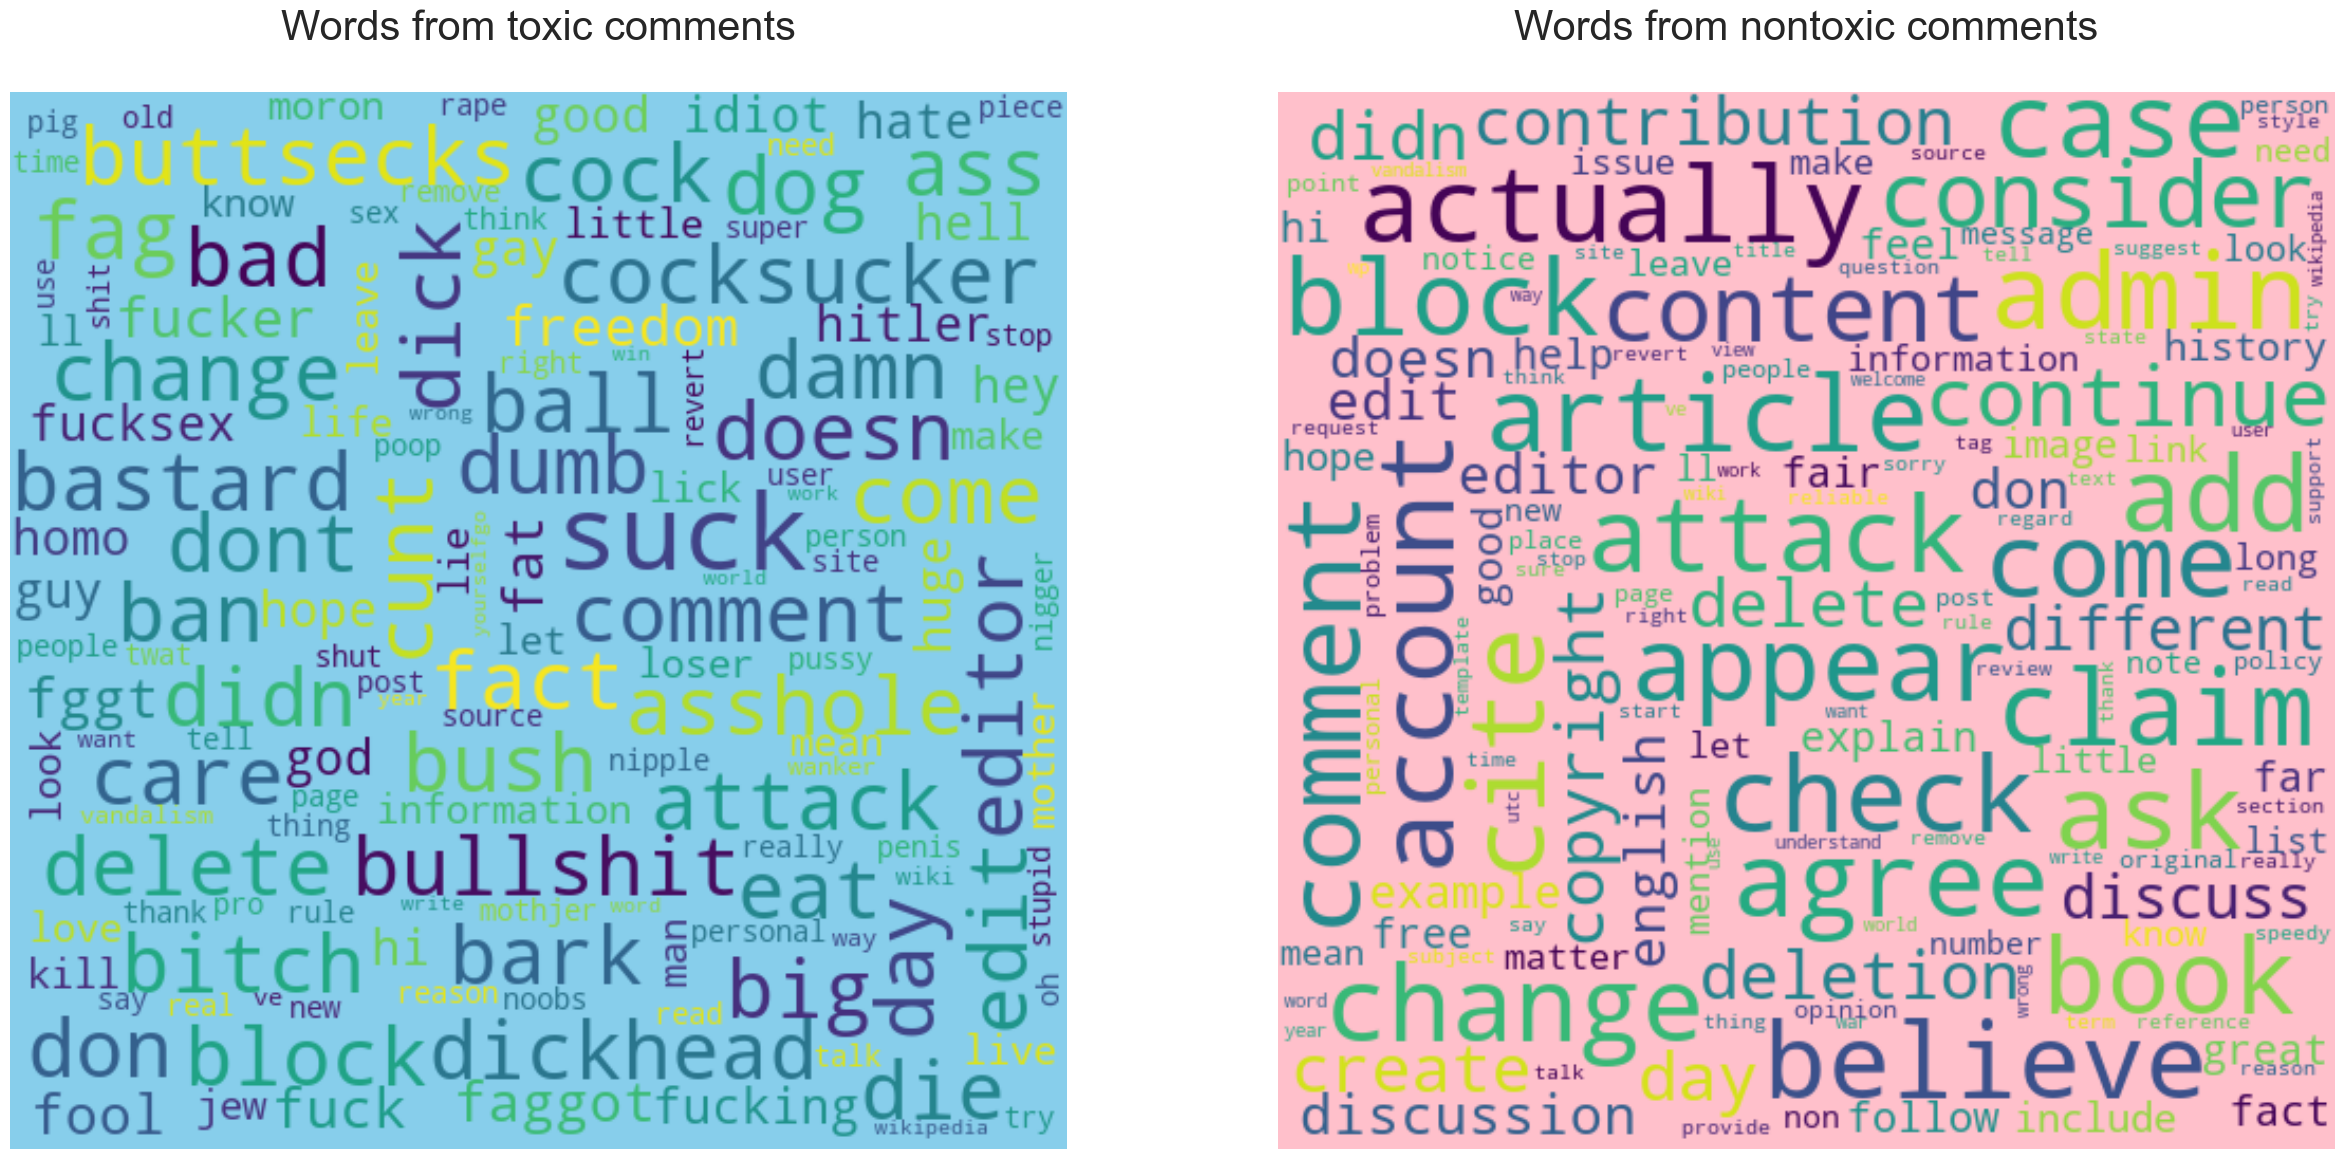

In [195]:
fig, ax = plt.subplots(1, 2, figsize  = (30, 30))

wordcloud_toxic = WordCloud(width=500, height=500, 
                            background_color="skyblue", max_font_size=50, 
                            stopwords = STOPWORDS).generate(str(count_vectorizer_t.get_feature_names()[4:]).replace("'",''))

wordcloud_nontoxic = WordCloud(width=500, height=500, 
                               background_color="pink", max_font_size=50,
                              stopwords = STOPWORDS).generate(str(count_vectorizer_nt.get_feature_names()).replace("'",''))

ax[0].imshow(wordcloud_toxic, interpolation='bilinear')
ax[0].set_title('Words from toxic comments\n', fontsize=30)
ax[0].axis('off')

ax[1].imshow(wordcloud_nontoxic, interpolation='bilinear')
ax[1].set_title('Words from nontoxic comments\n', fontsize=30)
ax[1].axis('off');

**Выводы**

- При проверке лучшей модели LinearSVC с подобранными гиперпараметрами на отложенной тестовой выборке с применением эмбеддингов BERT удалось получить итоговое значение метрики F1 равное 0.9028. 

- Таким образом, цель нашего исследования - дать магазину такой инструмент, который будет искать токсичные комментарии и отправлять их на модерацию - считаю дистигнутой.

## Выводы по исследованию

Целью нашего исследования являлось построение такой модели машинного обучения, которая помогала бы магазину искать токсичные комментарии и отправлять их на модерацию. Качество моделей оценивалось по метрике классификации F1-score, нужно было получить значение не меньше 0.75.

В нашем распоряжении был датасет, содержащий 159292 записи и две колонки: `text` с текстом комментария и `toxic` - целевой признак, оценка токсичности комментария (1 - токсичный, 0 - не токсичный).

Тексты комментариев были представлены на английском языке.

в ходе предобработки:

- Изучены данные и их основные характеристики, общая информация о датасете, рассмотрено наличие пропусков и явных дубликатов;
- Рассмотрено и визуализировано распределение целевого признака (оценки токсичности комментария), обнаружен дисбаланс классов с примерным соотношением токсичных комментариев к нетоксичным как 1:9;
- Из текстов комметариев были удалены все НЕ буквенные символы, лишние пробелы, тест был приведен к нижнему регистру и лемматизирован (все слова приведены к начальном форме);
- После этой процедуры в датасете были обнаружены явные дубликаты, после чего они были удалены.

Далее нами были обучены 4 классификатора (там где доступно, производился поиск наилучших гиперпараметров):

- линейная логистическая регрессия,
- линейную SVC (метод опорных векторов для классификации),
- деревянная Решающее дерево,
- бустинг LGBMClassiier.

Каждую модель мы опробовали как с обычным TfidfVectorizer, так и с создающим униграммы+биграммы, а также на эмбеддингах, полученных с помощью BERT. Результаты выведились в виде датафрейма и визуализировались матрицами ошибок моделей.

По результатам сравнительного анализа лучшей на валидации стала LinearSVC с подобранными гиперпараметрами и обучением на эмбеддингах BERT, так как значение метрики F1 на валидации для нее составило 0.8869. 

Наилучшая модель была протестирована на отложенной ранее тестовой выборке, которую до этого не видела ни одна модель. Таким образом, удалось получить итоговое значение метрики F1-score равное 0.9028, что значительно выше порога заказчика в 0.75.

Таким образом, цель исследования по поиску оптимальной по качеству предсказаний токсичности комментария модели была решена с помощью модели Support Vector Classification.